# Exective summary of Work Package 3

## Objectives

In this WP, you will work on a given training dataset. Your goal is to develop a fault detection model using the regression algorithms learnt in the class, in order to achieve best F1 score。

## Tasks

- Task 1: Develop a regression model to predict the reference value for motor temperature.
- Task 2: Develop a fault detection model using the regression model you developed in Task 1.

## Delierables

- A Jupyter notebook reporting the process and results of the above tasks


# Before starting, please:
- Fetch the most up-to-date version of the github repository.
- Create a new branch with your name, based on the "main" branch and switch to your own branch.
- Copy this notebook to the work space of your group, and rename it to TD_WP_3_Your name.ipynb
- After finishing this task, push your changes to the github repository of your group.

# Task 1: Predict normal behaviors through regression models

In this task, let us try to develop a best regression model to predict the normal behaviors of a given motor. In this exercise, we can use motor 6 as an example. You can easilily generate the approach to other models for the data challenge.

We can use all the dataset where motor 6 works normally as our dataset. Then, we can run a cross validation (based on sequence, not points) to test the performances of the developed model.

In this example, we mainly use the following performance metrics:
- max error: The max error between the predicted and the true values.
- Mean root squared error: The mean root squared error between the predicted and the true values.
- Out-of-boundary rate: The percentage that the residual error between the predicted and the true values is larger than a given threshold. Here, we set the thresold to be $3$ degree.

## Sub-task 1: Only use the features at the current moment.

[This notebook](demo_regression_mdl.ipynb) provides a basic demonstration of how to set up the experiment. Let us start by considering only using the features from the current moment. In the notebook, we show a baseline using a simple linear regression with all the features. Could you please try to improve the performance of the model?

A few possible directions:
- Feature selection?
- Smoothing?
- Removing sequence-to-sequence variablity? Adding features regarding time dynamics (see the TD for last lecture).
- Changing to other regression models? For this, you can try different regression models from [here](https://scikit-learn.org/stable/supervised_learning.html)

Put your code below.

In [1]:
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd


def pre_processing(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

In [2]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt


# Function to design a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


# Function to apply the Butterworth low-pass filter
def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Set parameters for the low-pass filter
cutoff_frequency = .5  # Adjust as needed
sampling_frequency = 10  # Assuming your data is evenly spaced in time


def customized_outlier_removal(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    # df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    # df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # Make sure that the difference between the current and previous temperature cannot be too large.
    # Define your threshold
    threshold = 10
    # Shift the 'temperature' column by one row to get the previous temperature
    prev_tmp = df['temperature'].shift(1)
    # Calculate the absolute difference between current and previous temperature
    temp_diff = np.abs(df['temperature'] - prev_tmp)
    # Set the temperature to NaN where the difference is larger than the threshold
    df.loc[temp_diff > threshold, 'temperature'] = np.nan
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    # df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    # df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()
    

from utility import read_all_csvs_one_test
import matplotlib.pyplot as plt
import pandas as pd
import os

# Get all the folders in the base_dictionary
path_list = os.listdir(base_dictionary)
# Only keep the folders, not the excel file.
path_list = path_list[:-1]

# Read the data.
df_data_smoothing = pd.DataFrame()
for tmp_path in path_list:
    path = base_dictionary + tmp_path
    # Read the data with the customized outlier removal function.
    tmp_df = read_all_csvs_one_test(path, tmp_path, customized_outlier_removal)
    df_data_smoothing = pd.concat([df_data_smoothing, tmp_df])
    df_data_smoothing = df_data_smoothing.reset_index(drop=True)

# Read the test conditions
df_test_conditions = pd.read_excel(base_dictionary+'Test conditions.xlsx')

# Visulize the data
# for selected_sequence_idx in path_list:
#     filtered_df = df_data_smoothing[df_data_smoothing['test_condition'] == selected_sequence_idx]

#     print('{}: {}\n'.format(selected_sequence_idx, df_test_conditions[df_test_conditions['Test id'] == selected_sequence_idx]['Description']))

#     fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
#     for ax, col in zip(axes.flat, ['data_motor_1_position', 'data_motor_2_position', 'data_motor_3_position', 
#         'data_motor_1_temperature', 'data_motor_2_temperature', 'data_motor_3_temperature',
#         'data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage']):
#         ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)
#         ax.set_ylabel(col)

#     fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
#     for ax, col in zip(axes.flat, ['data_motor_4_position', 'data_motor_5_position', 'data_motor_6_position',
#         'data_motor_4_temperature', 'data_motor_5_temperature', 'data_motor_6_temperature',
#         'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage']):
#         ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)
#         ax.set_ylabel(col)

#     plt.show()

In [3]:
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']
df_data = df_data[df_data['test_condition'].isin(normal_test_id)]
df_data_smoothing = df_data_smoothing[df_data_smoothing['test_condition'].isin(normal_test_id)]


## Support vector Machine

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn import svm

steps1 = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', svm.SVR())    # Step 2: SVM
]

# Create the pipeline
mdl_SVM = Pipeline(steps1)

Model for motor 6:


c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 6.178752174208402
training performance, mean root square error is: 0.6663077488126287
training performance, residual error > 2: 1.7649903288201159%

 New run:

testing performance, max error is: 5.080523069948665
testing performance, mean root square error is: 2.842310482731927
testing performance, residual error > 2: 83.926205279788%


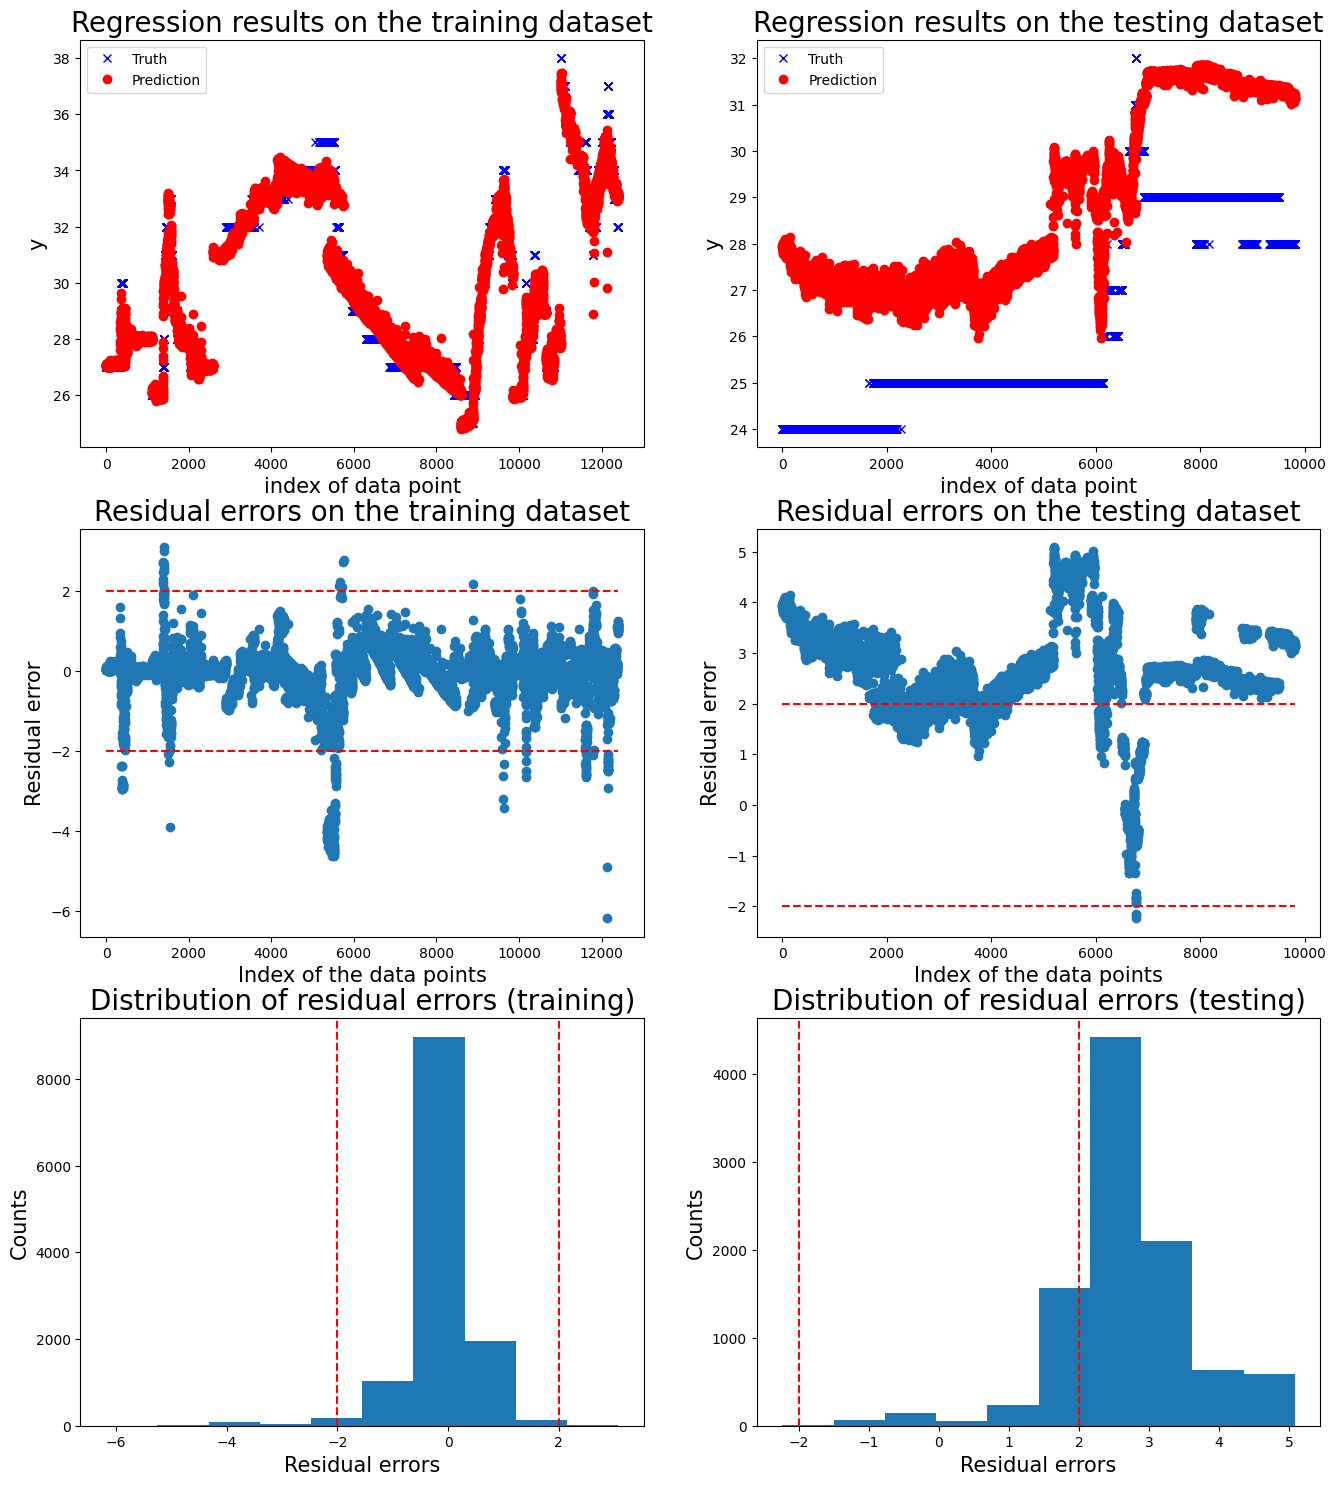

c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 6.2779126517970845
training performance, mean root square error is: 0.516077450746895
training performance, residual error > 2: 1.0094308326619592%

 New run:

testing performance, max error is: 3.6932198246090877
testing performance, mean root square error is: 0.9414399063995026
testing performance, residual error > 2: 2.862254025044723%


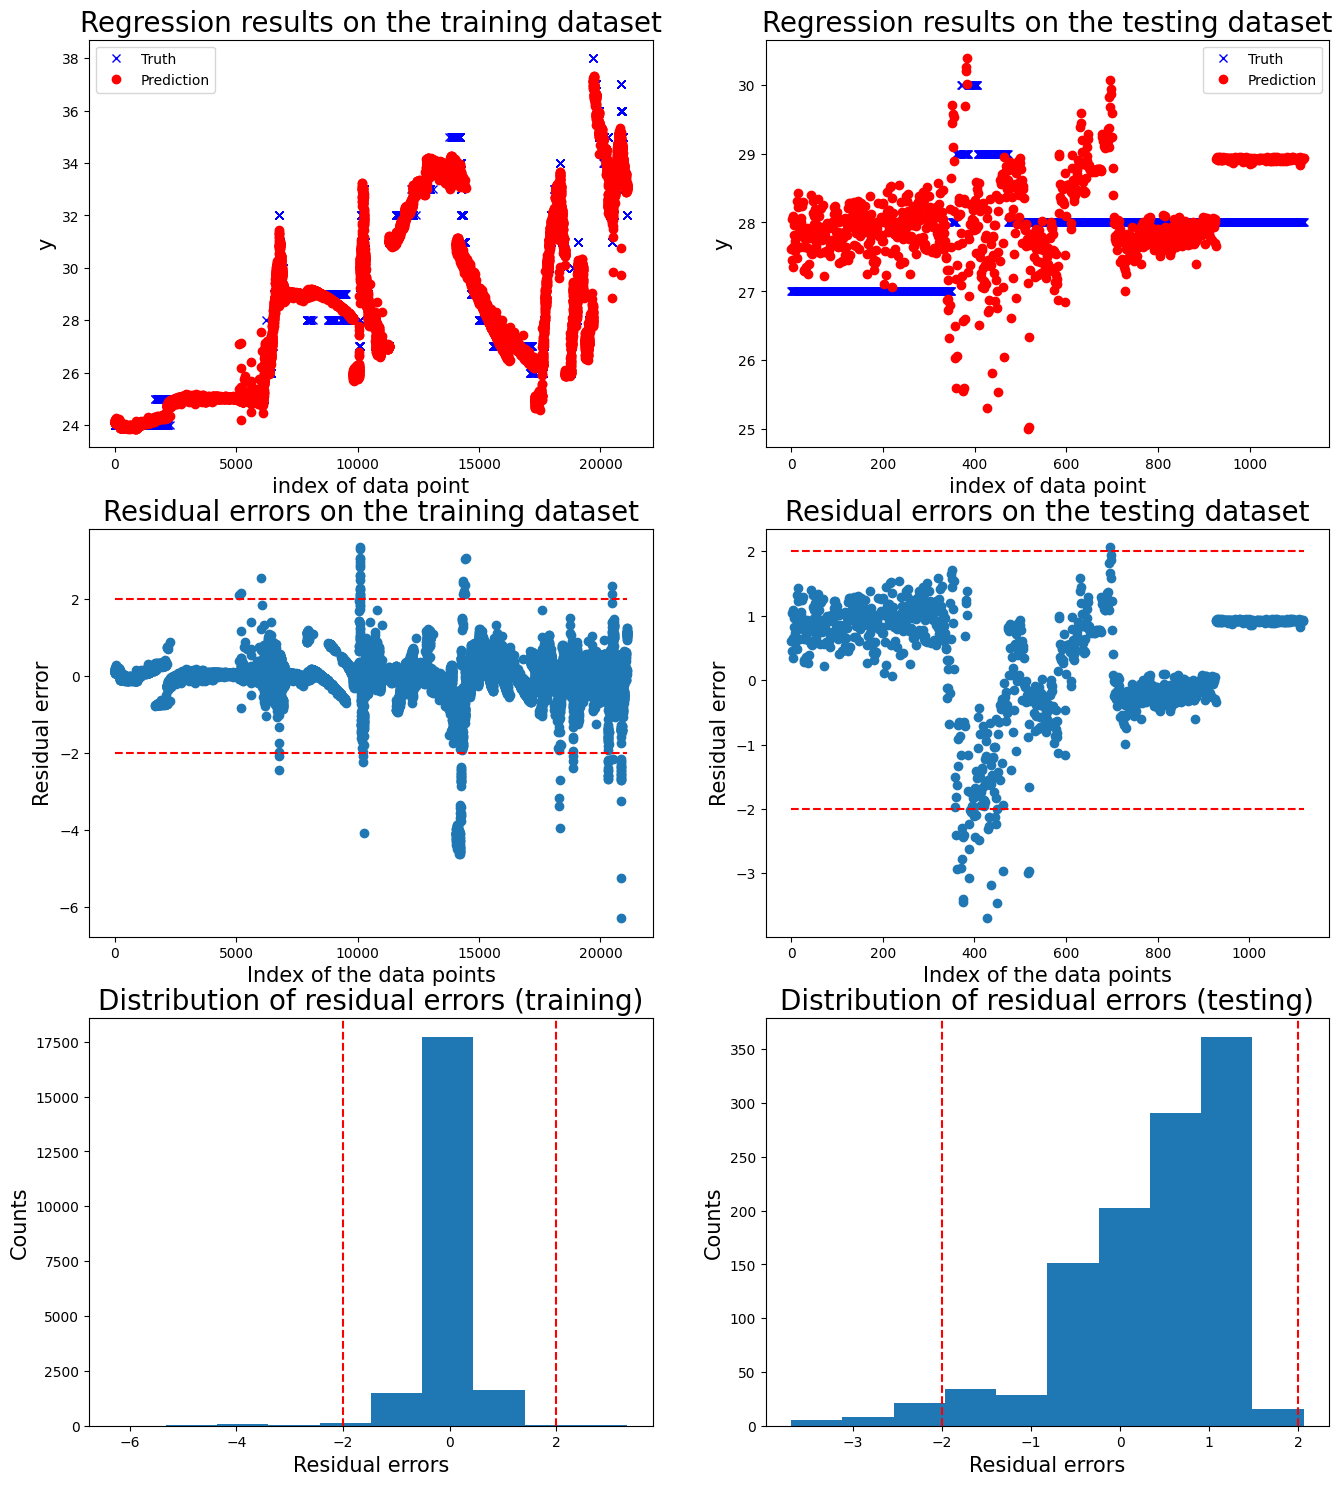

c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 6.308028485994711
training performance, mean root square error is: 0.35219718762332053
training performance, residual error > 2: 0.46715111967966777%

 New run:

testing performance, max error is: 7.8826290770492875
testing performance, mean root square error is: 3.85691763983006
testing performance, residual error > 2: 55.273102026794916%


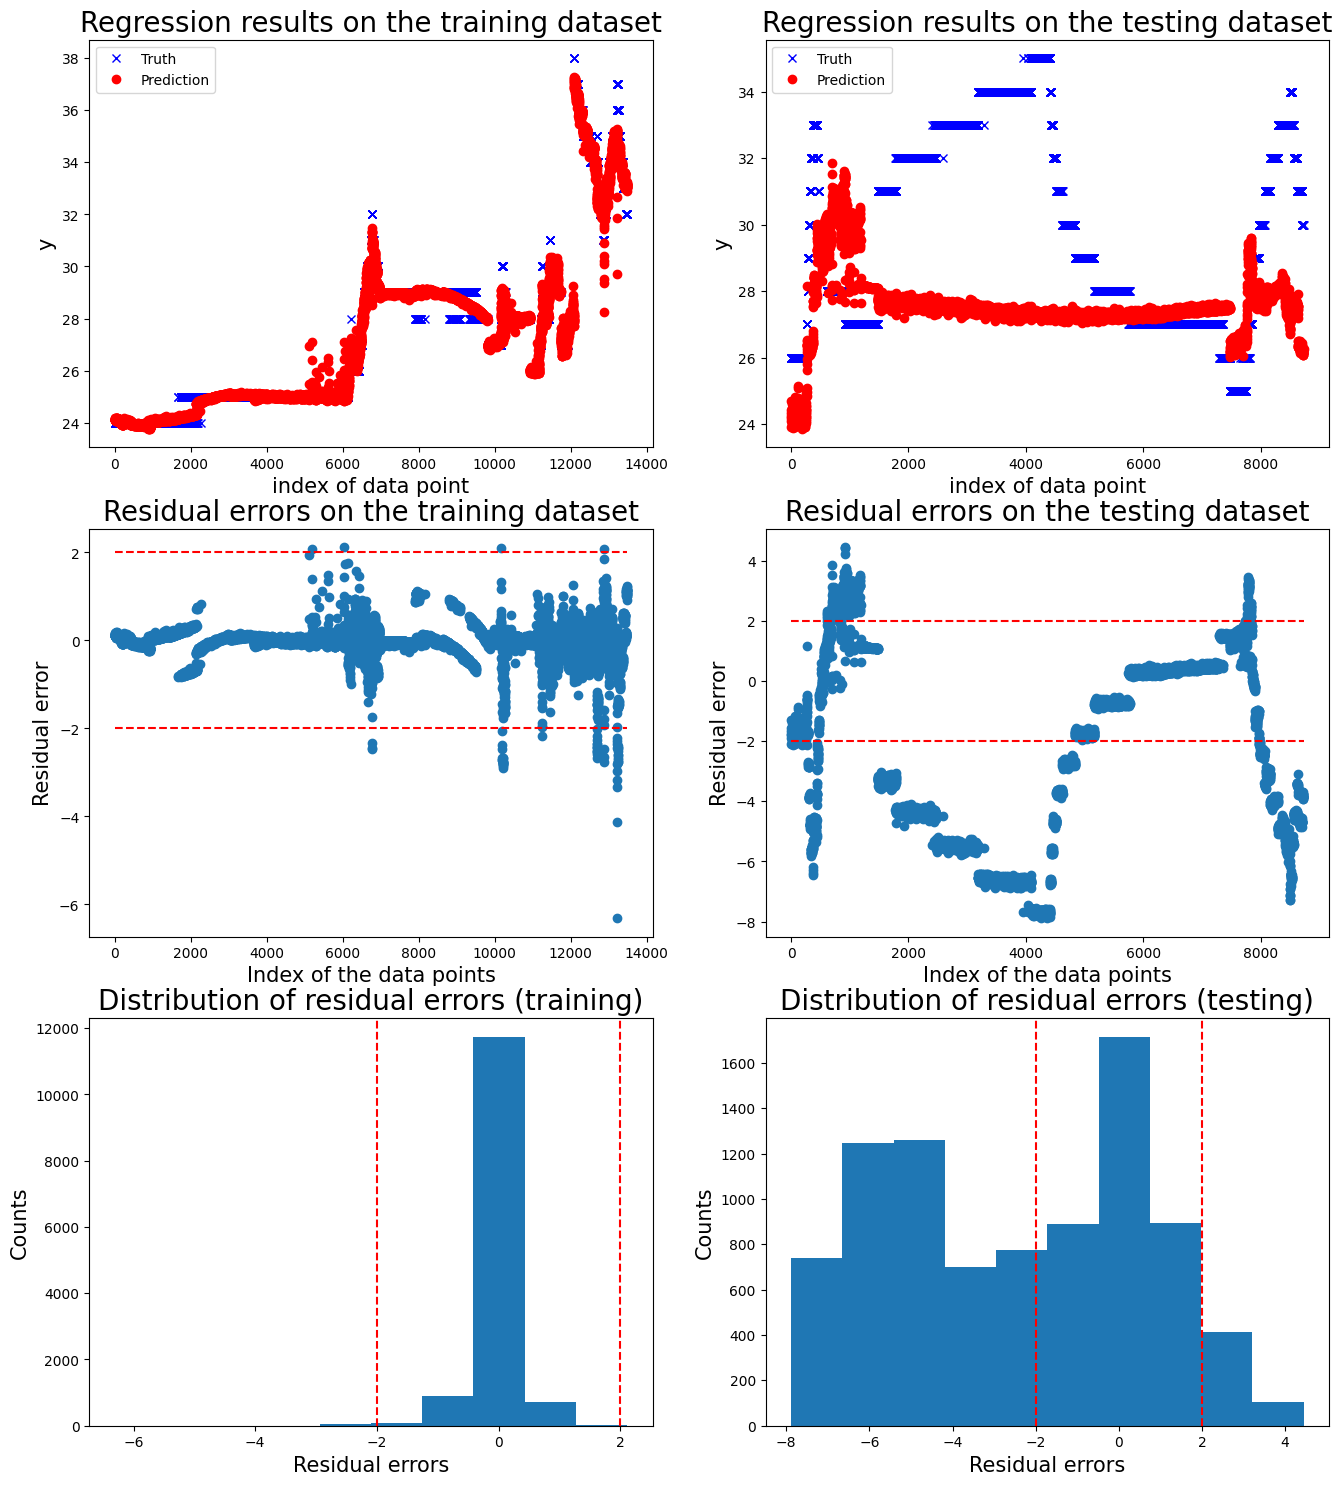

c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 6.323727463780369
training performance, mean root square error is: 0.5140129960516345
training performance, residual error > 2: 1.0506654214335747%

 New run:

testing performance, max error is: 3.772655076461117
testing performance, mean root square error is: 2.183050574752596
testing performance, residual error > 2: 35.9452736318408%


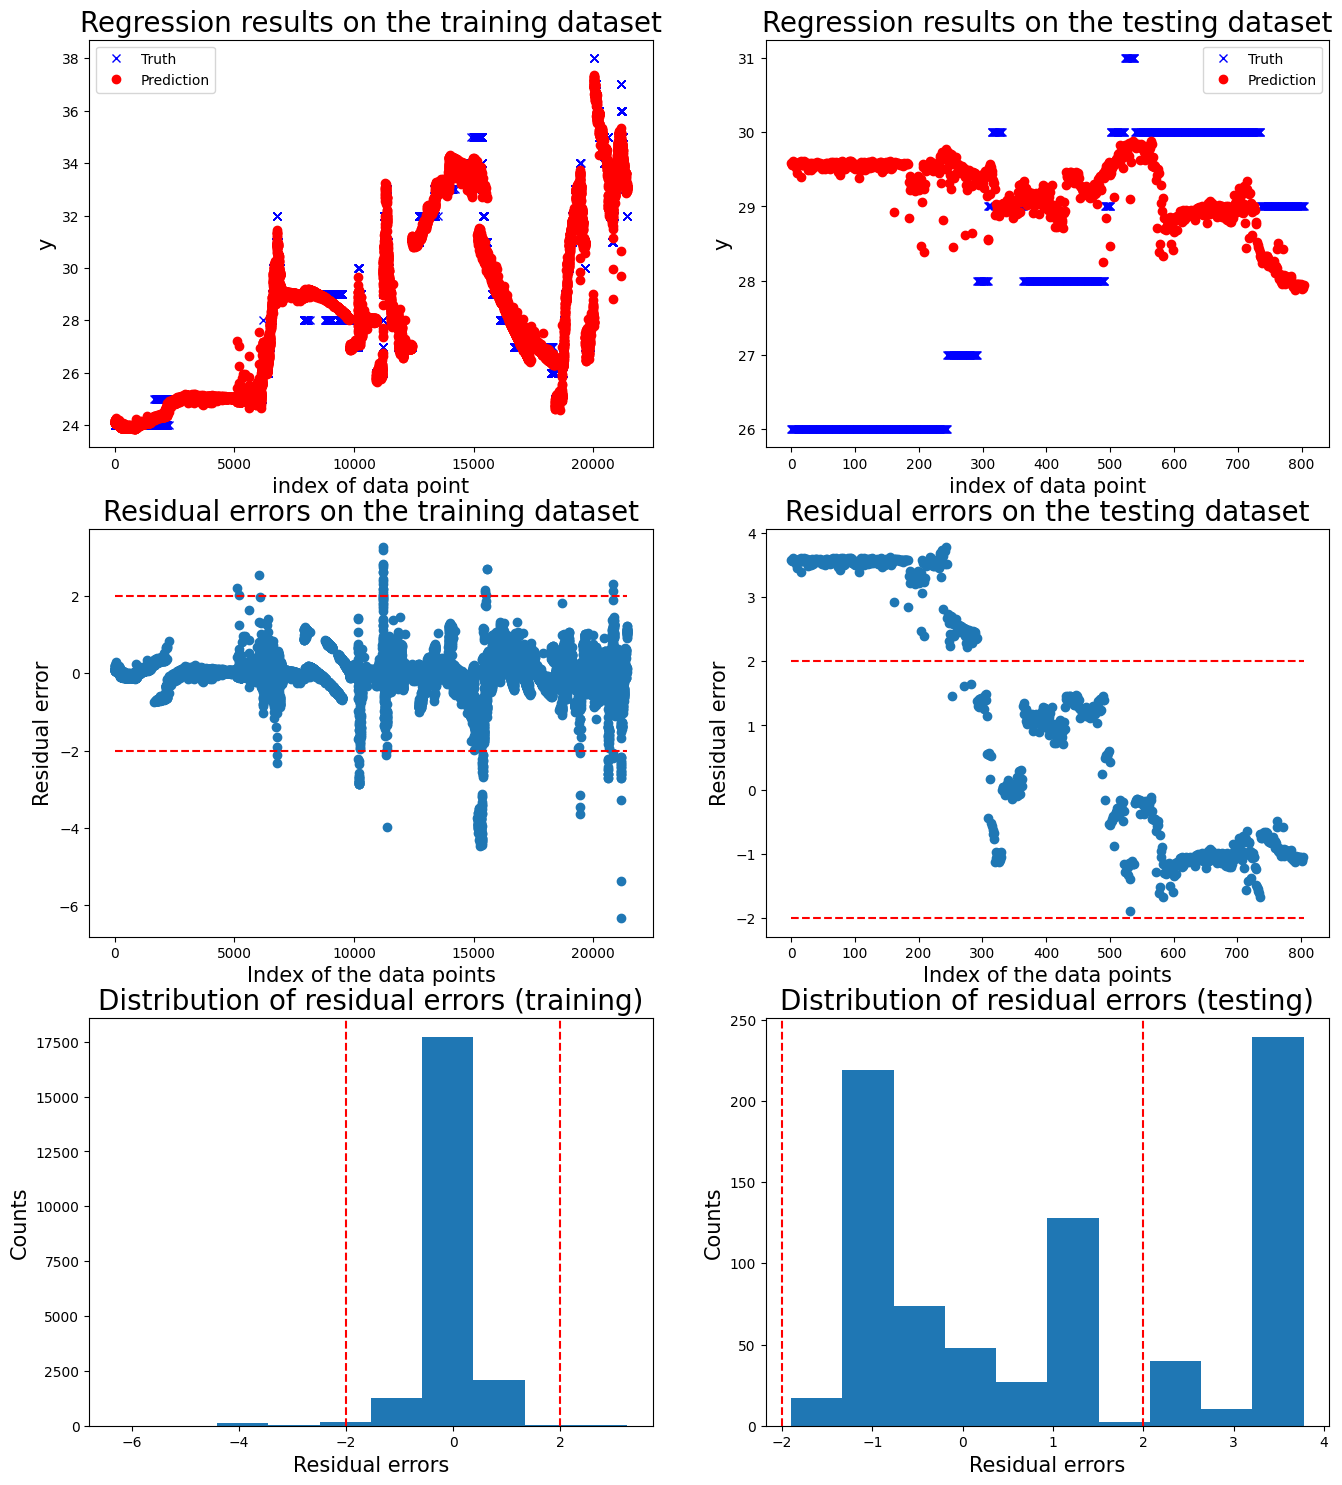

c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 4.502376141302829
training performance, mean root square error is: 0.5021694419153773
training performance, residual error > 2: 0.9479136128212646%

 New run:

testing performance, max error is: 10.807953970437921
testing performance, mean root square error is: 6.341094445027308
testing performance, residual error > 2: 79.74900171135197%


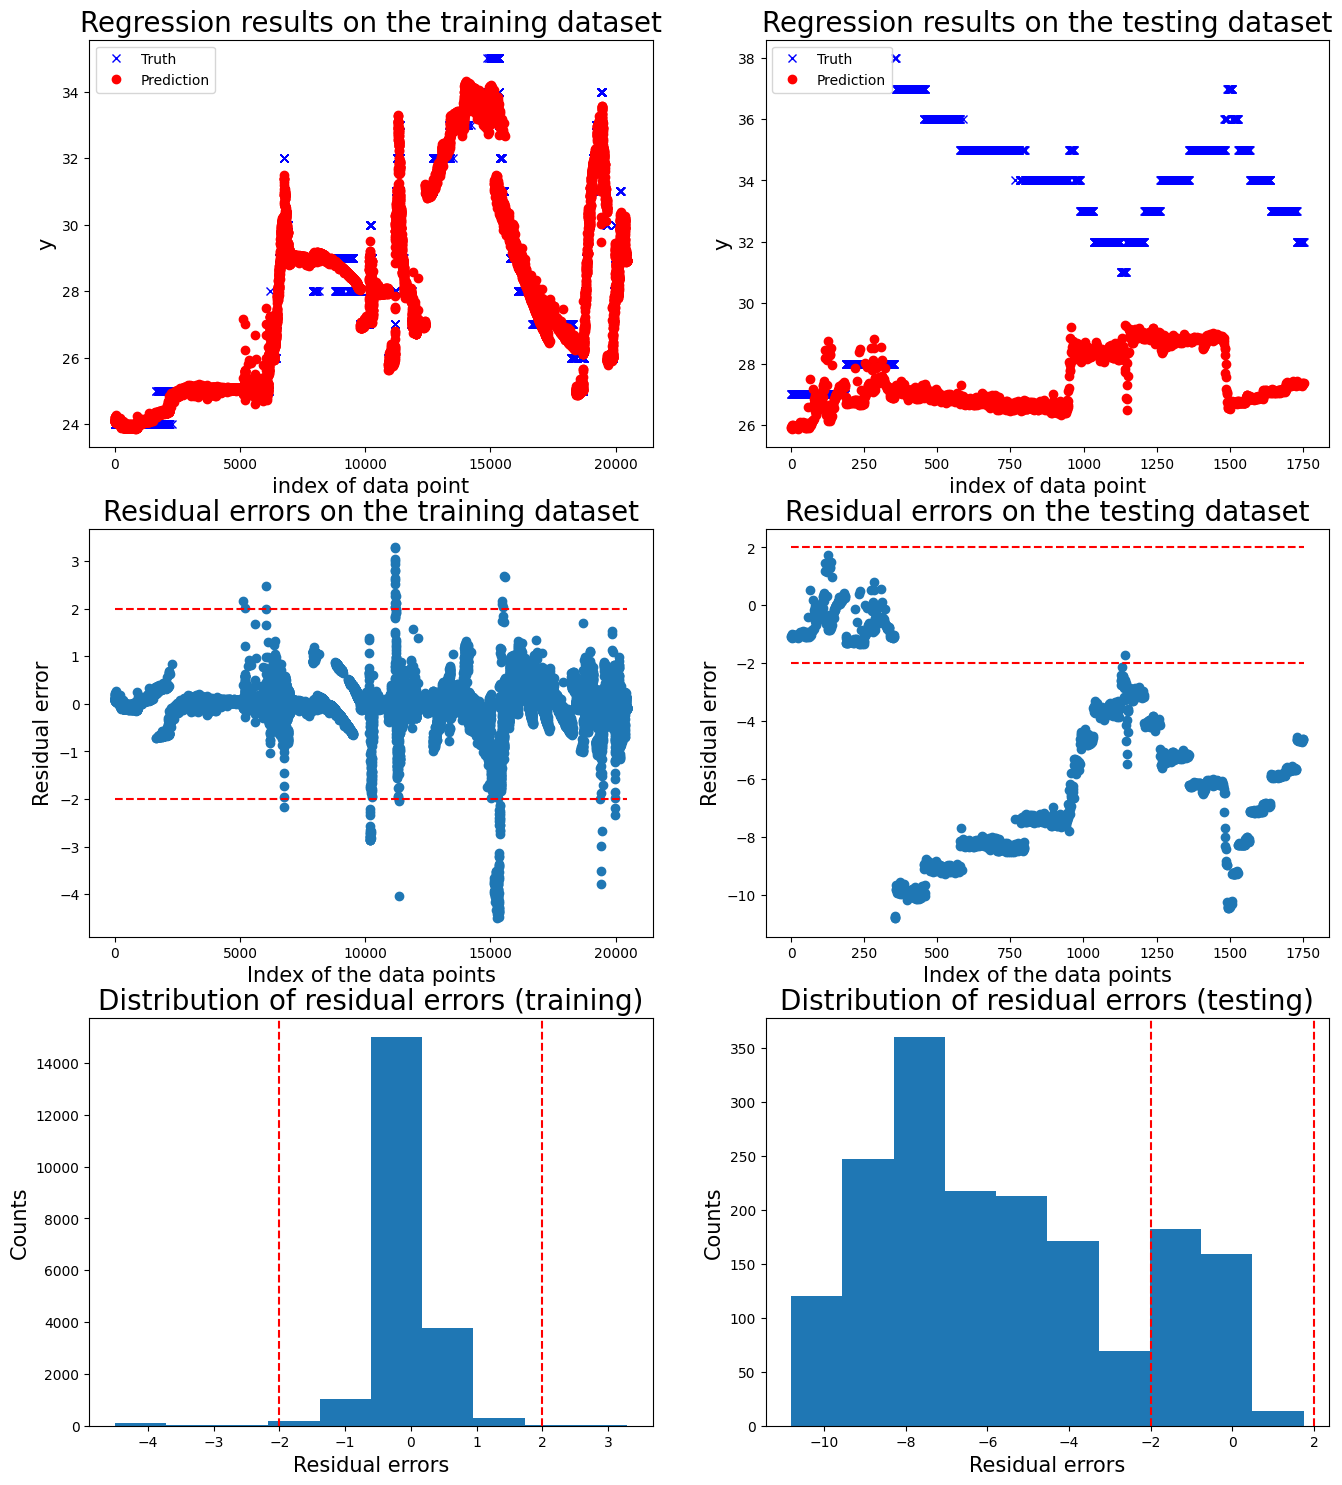

   Max error      RMSE  Exceed boundary rate
0   5.080523  2.842310              0.839262
1   3.693220  0.941440              0.028623
2   7.882629  3.856918              0.552731
3   3.772655  2.183051              0.359453
4  10.807954  6.341094              0.797490


Mean performance metric and standard error:
Max error: 6.2474 +- 3.0611
RMSE: 3.2330 +- 2.0344
Exceed boundary rate: 0.5155 +- 0.3343




In [5]:
from utility import run_cv_one_motor


feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

threshold = 2
window_size = 1
sample_step = 1

df_perf = run_cv_one_motor(motor_idx=6, df_data=df_data_smoothing, mdl=mdl_SVM, 
            feature_list=feature_list_all, n_fold=5, 
            threshold=threshold, window_size=window_size, sample_step=sample_step, mdl_type='reg')

## Lasso Regression

Model for motor 6:

 New run:

training performance, max error is: 1.2001315531867434
training performance, mean root square error is: 0.15750816932589035
training performance, residual error > 2: 0.0%

 New run:

testing performance, max error is: 1.1677262481167432
testing performance, mean root square error is: 0.21550037843333159
testing performance, residual error > 2: 0.0%


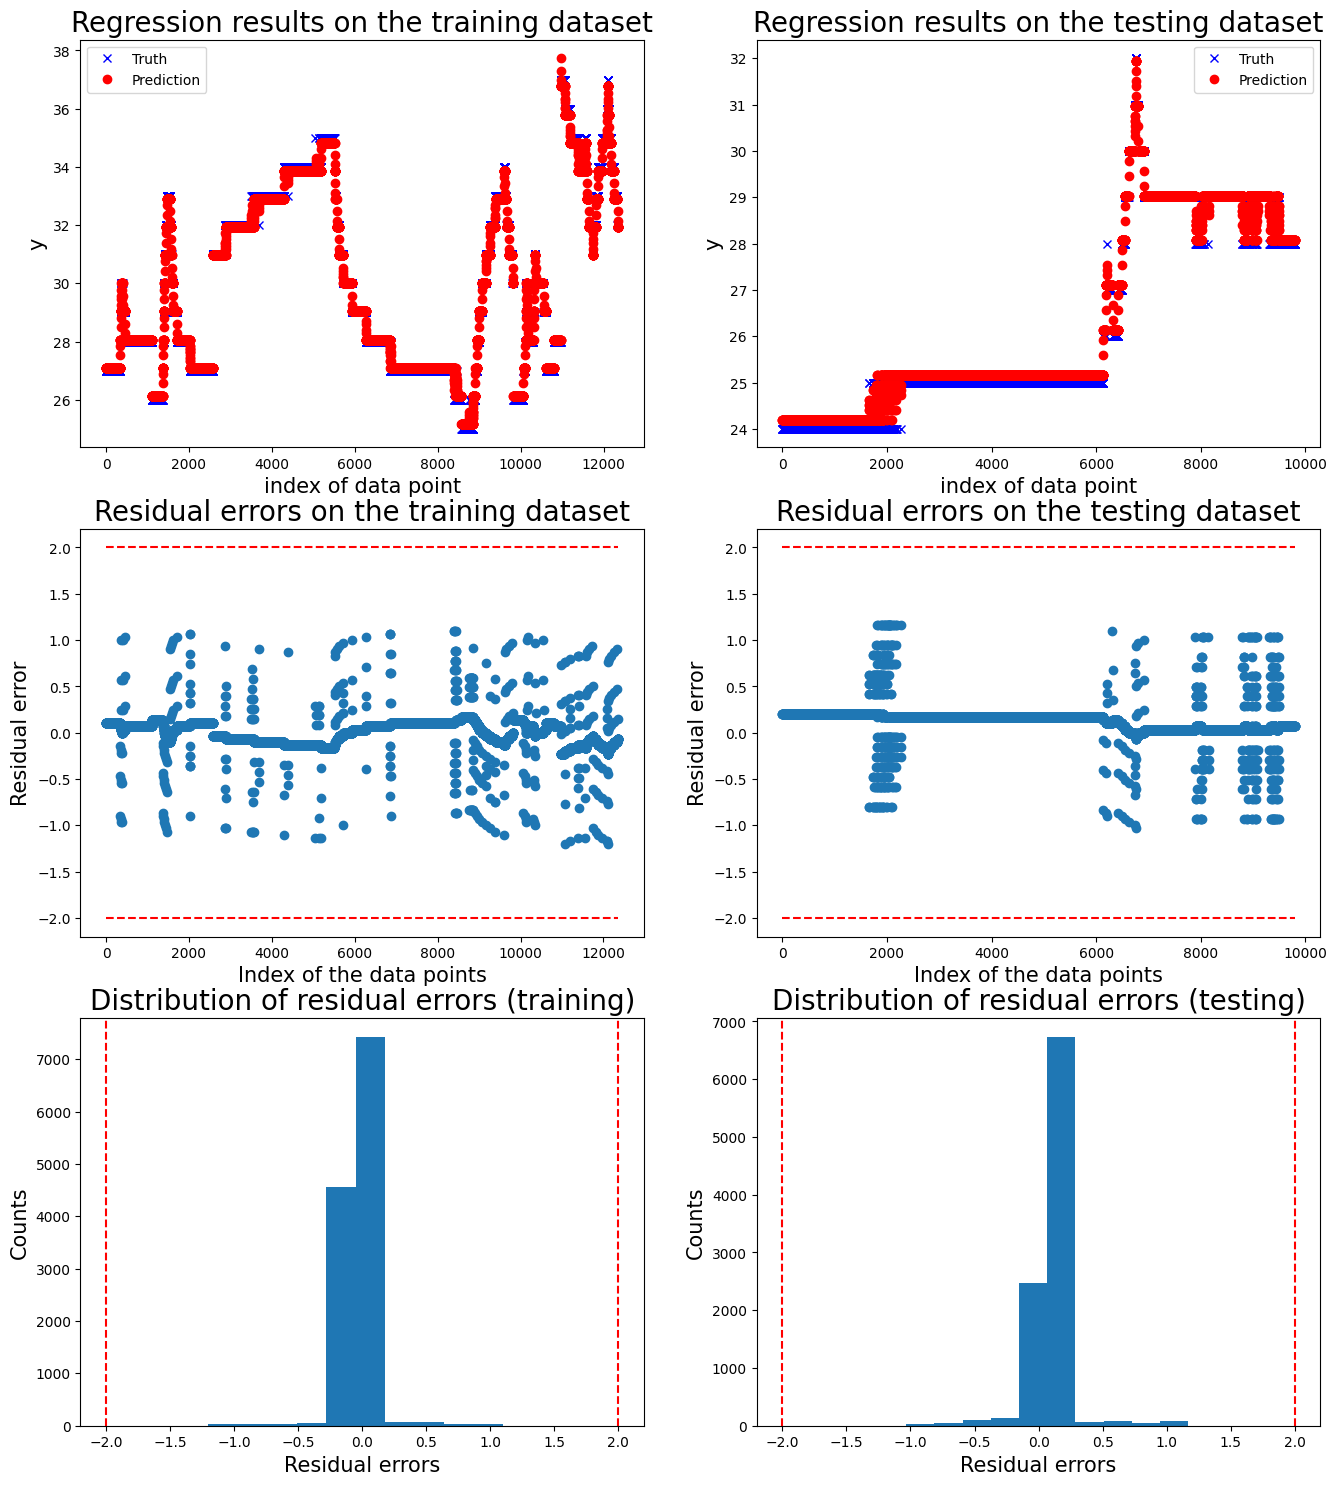


 New run:

training performance, max error is: 1.233416333250112
training performance, mean root square error is: 0.17384650887693842
training performance, residual error > 2: 0.0%

 New run:

testing performance, max error is: 1.0197042013024422
testing performance, mean root square error is: 0.10274088918589656
testing performance, residual error > 2: 0.0%


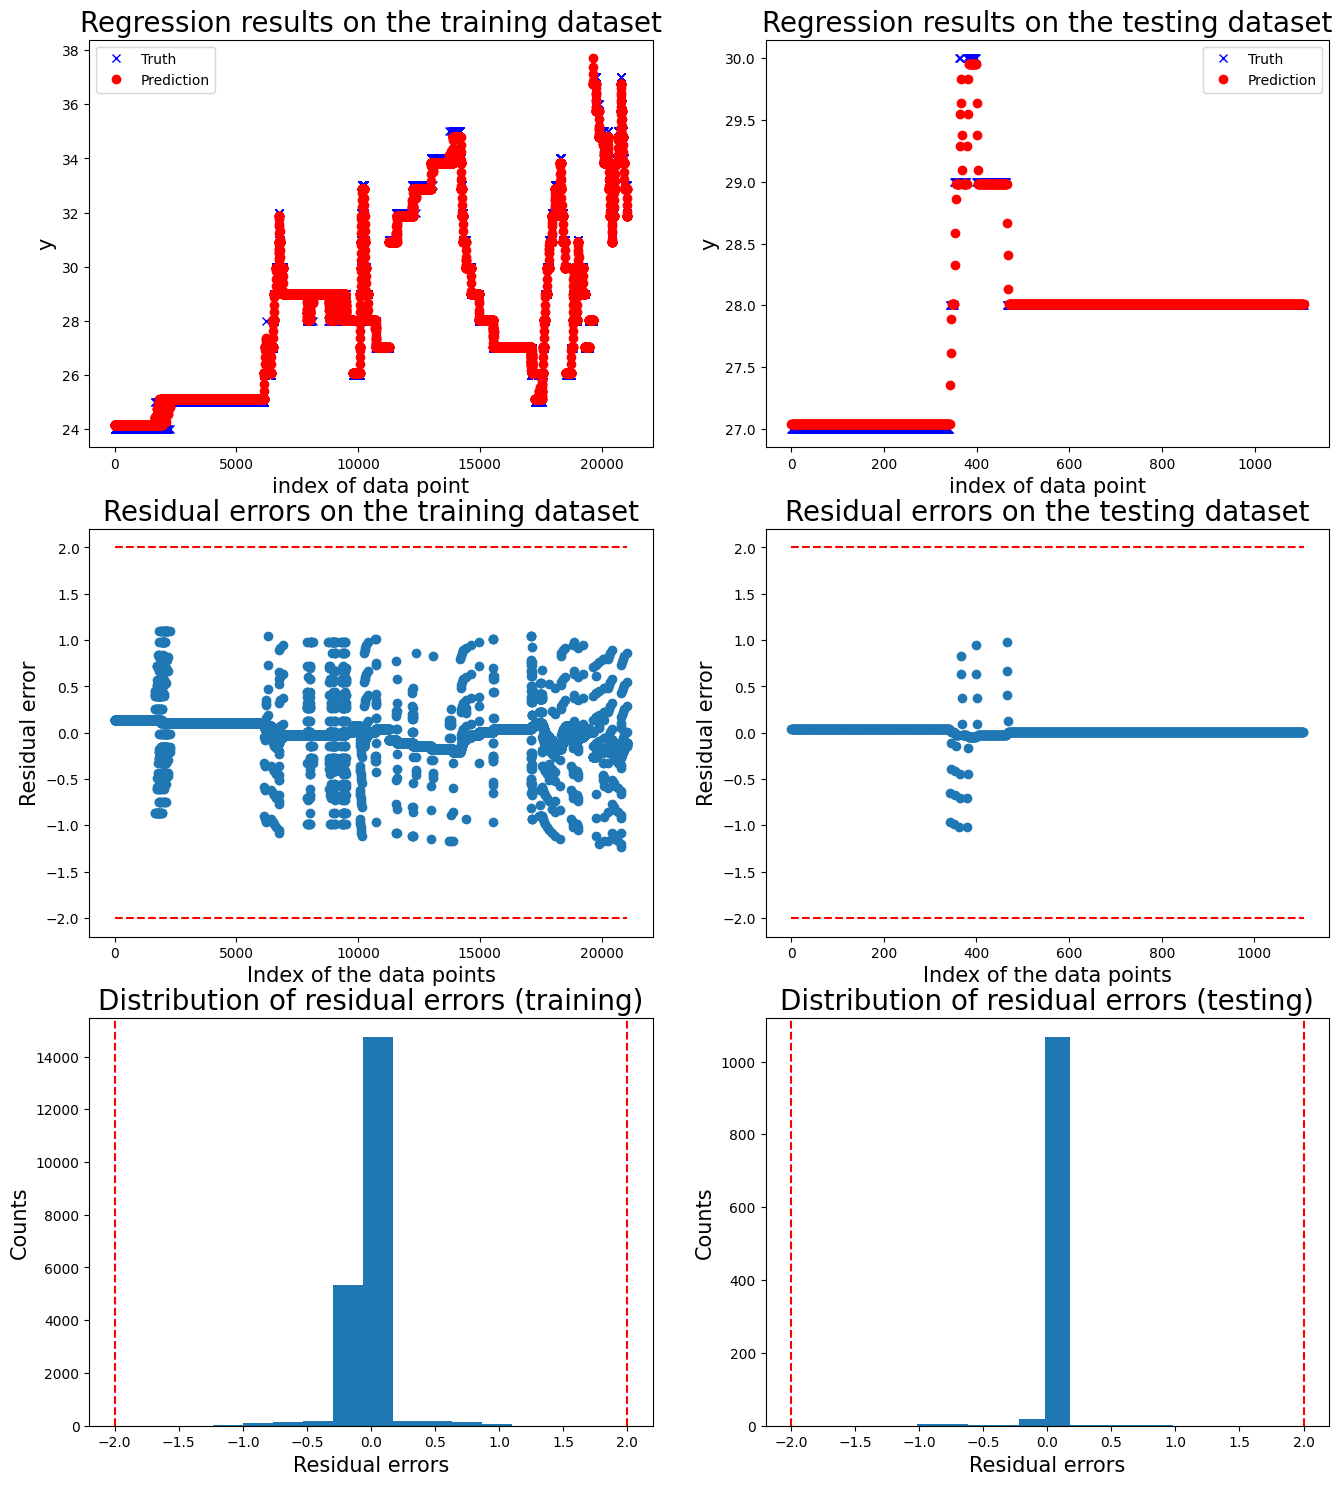


 New run:

training performance, max error is: 1.292393477188888
training performance, mean root square error is: 0.1811035847512549
training performance, residual error > 2: 0.0%

 New run:

testing performance, max error is: 1.2250634489453063
testing performance, mean root square error is: 0.1765821432907779
testing performance, residual error > 2: 0.0%


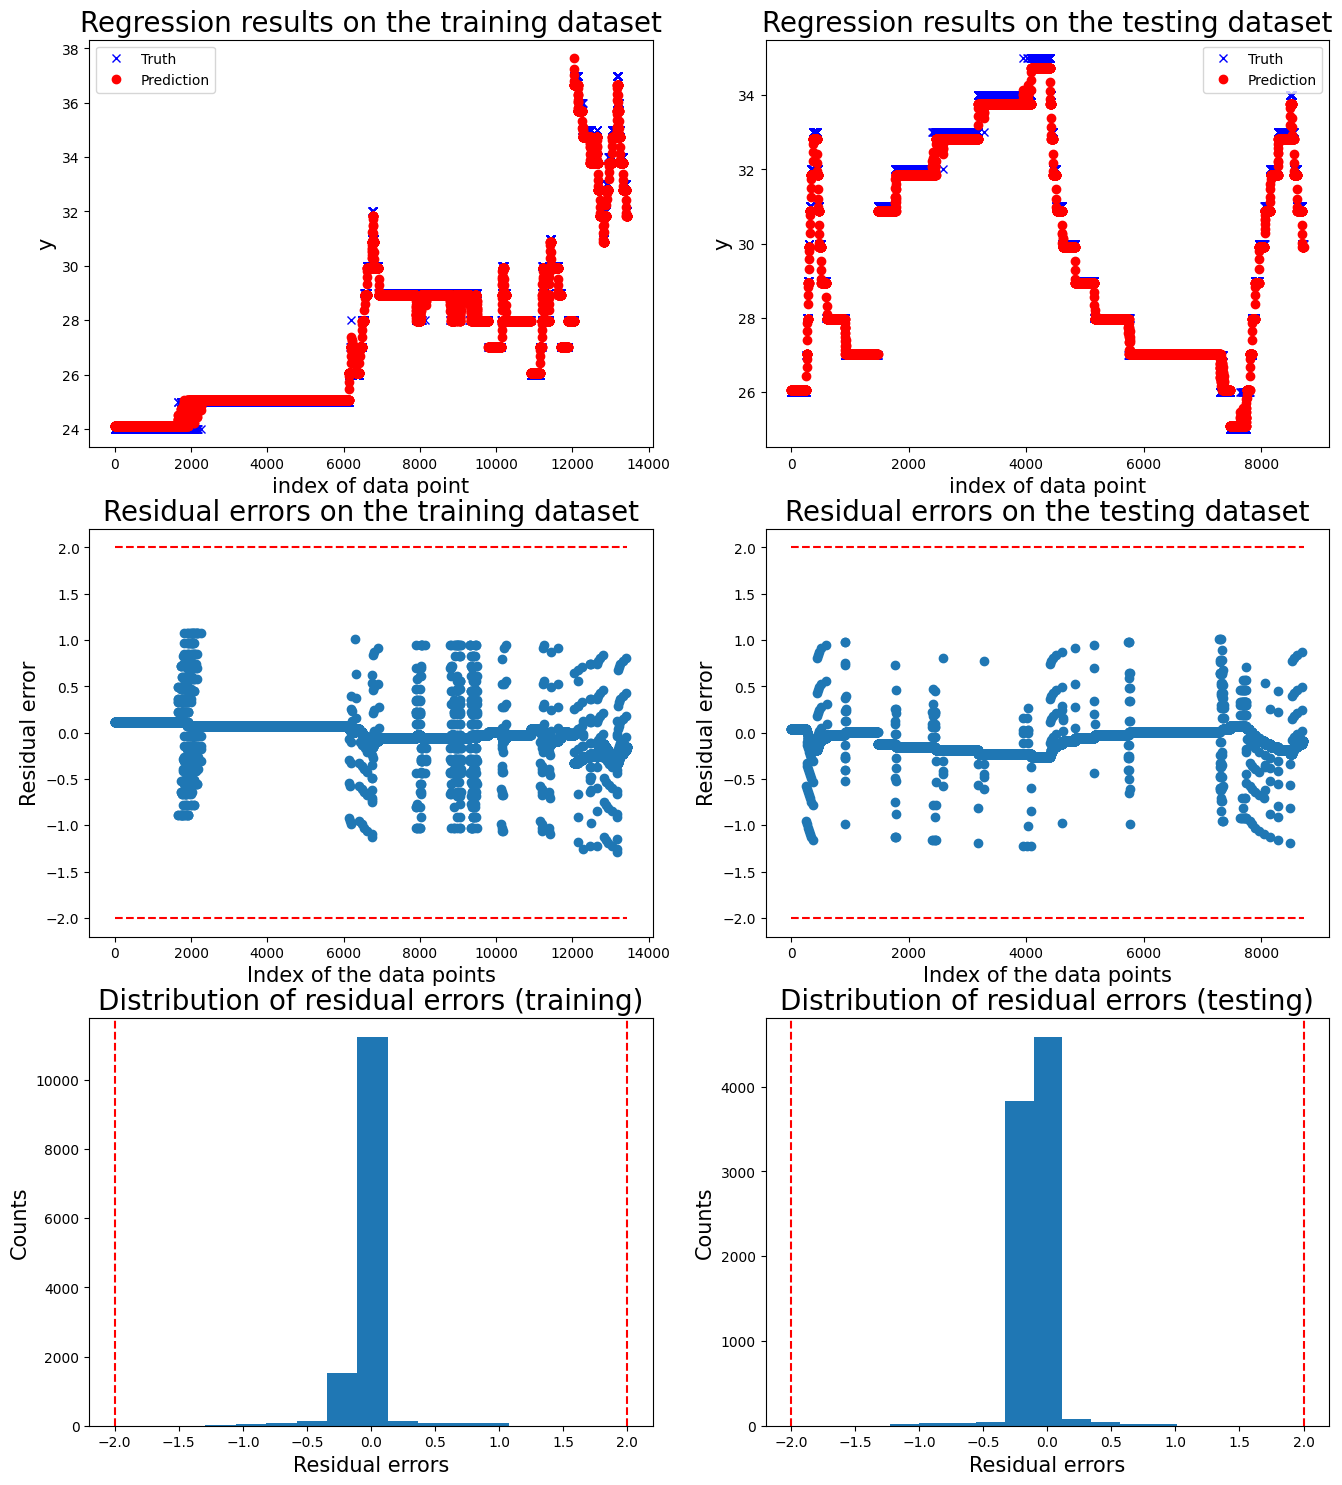


 New run:

training performance, max error is: 1.236483847358123
training performance, mean root square error is: 0.17216717056580852
training performance, residual error > 2: 0.0%

 New run:

testing performance, max error is: 1.0515239461958963
testing performance, mean root square error is: 0.15790104651243192
testing performance, residual error > 2: 0.0%


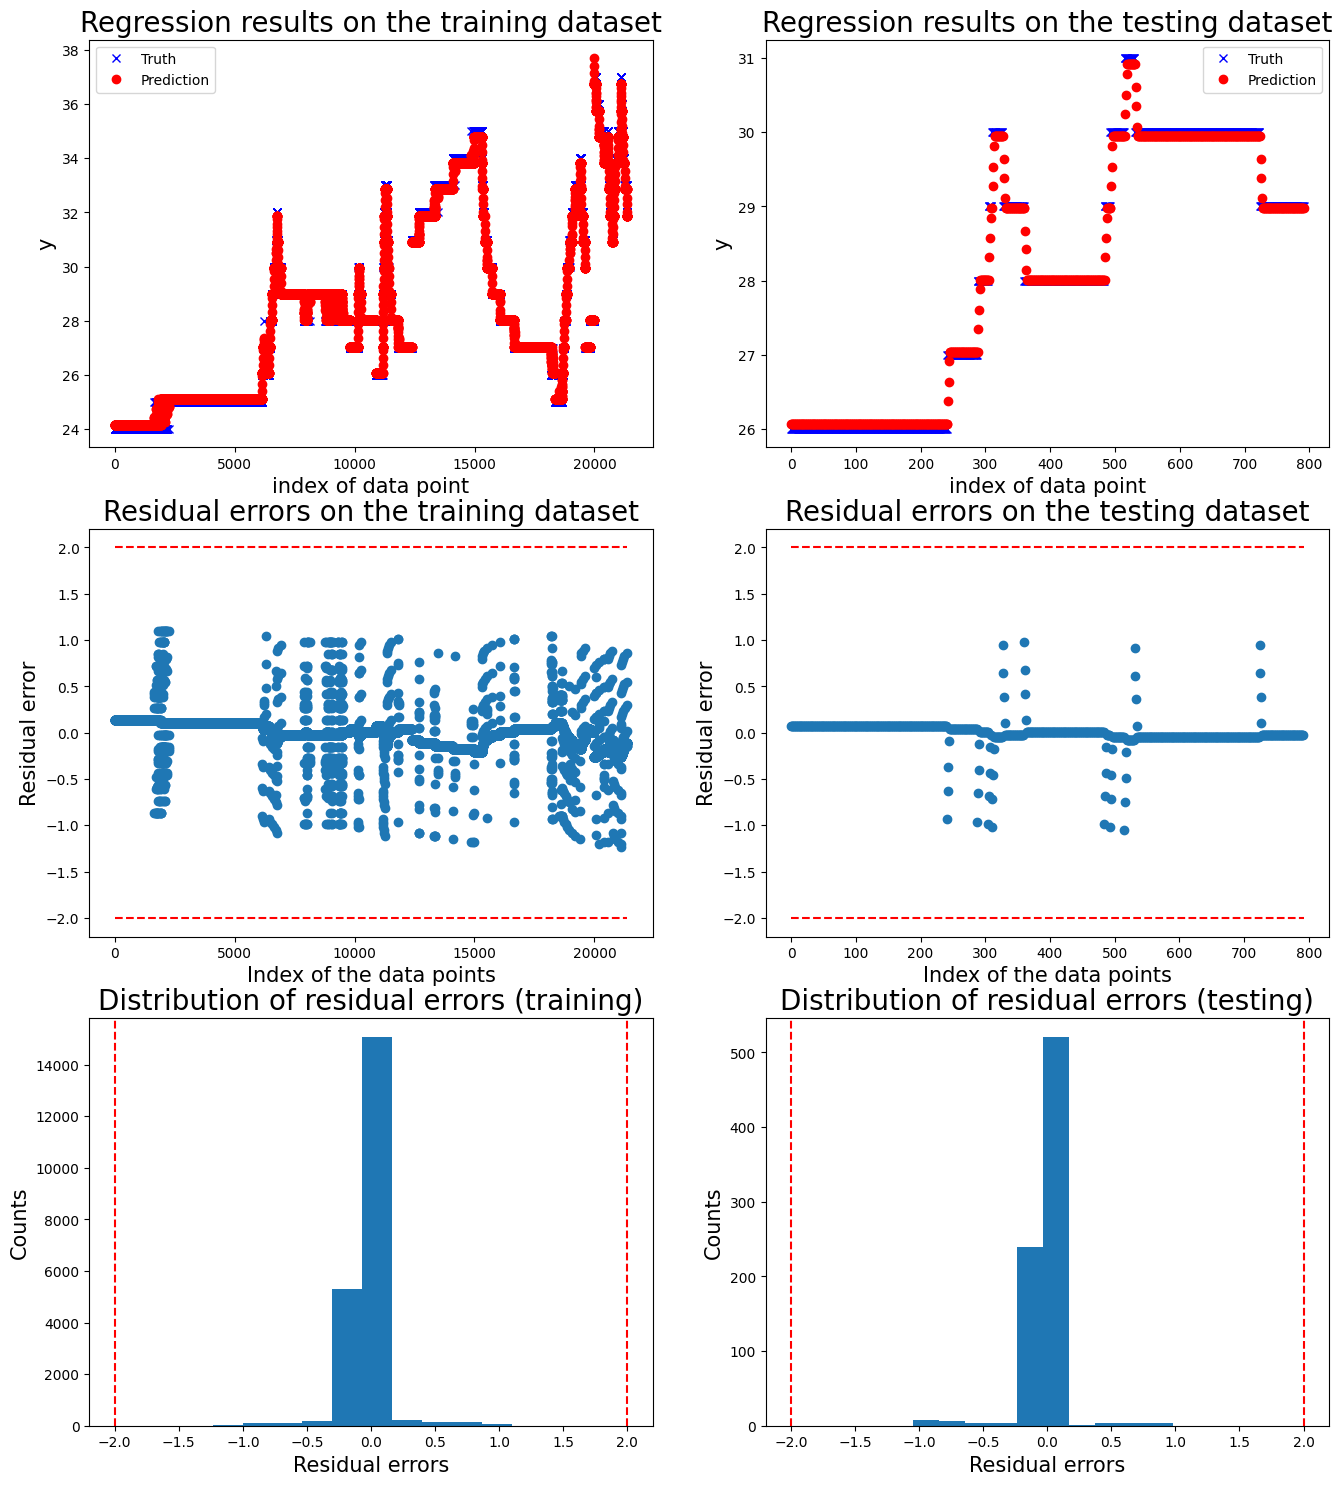


 New run:

training performance, max error is: 1.2057779473080643
training performance, mean root square error is: 0.1710612614581756
training performance, residual error > 2: 0.0%

 New run:

testing performance, max error is: 1.2738403098072482
testing performance, mean root square error is: 0.24403169683231407
testing performance, residual error > 2: 0.0%


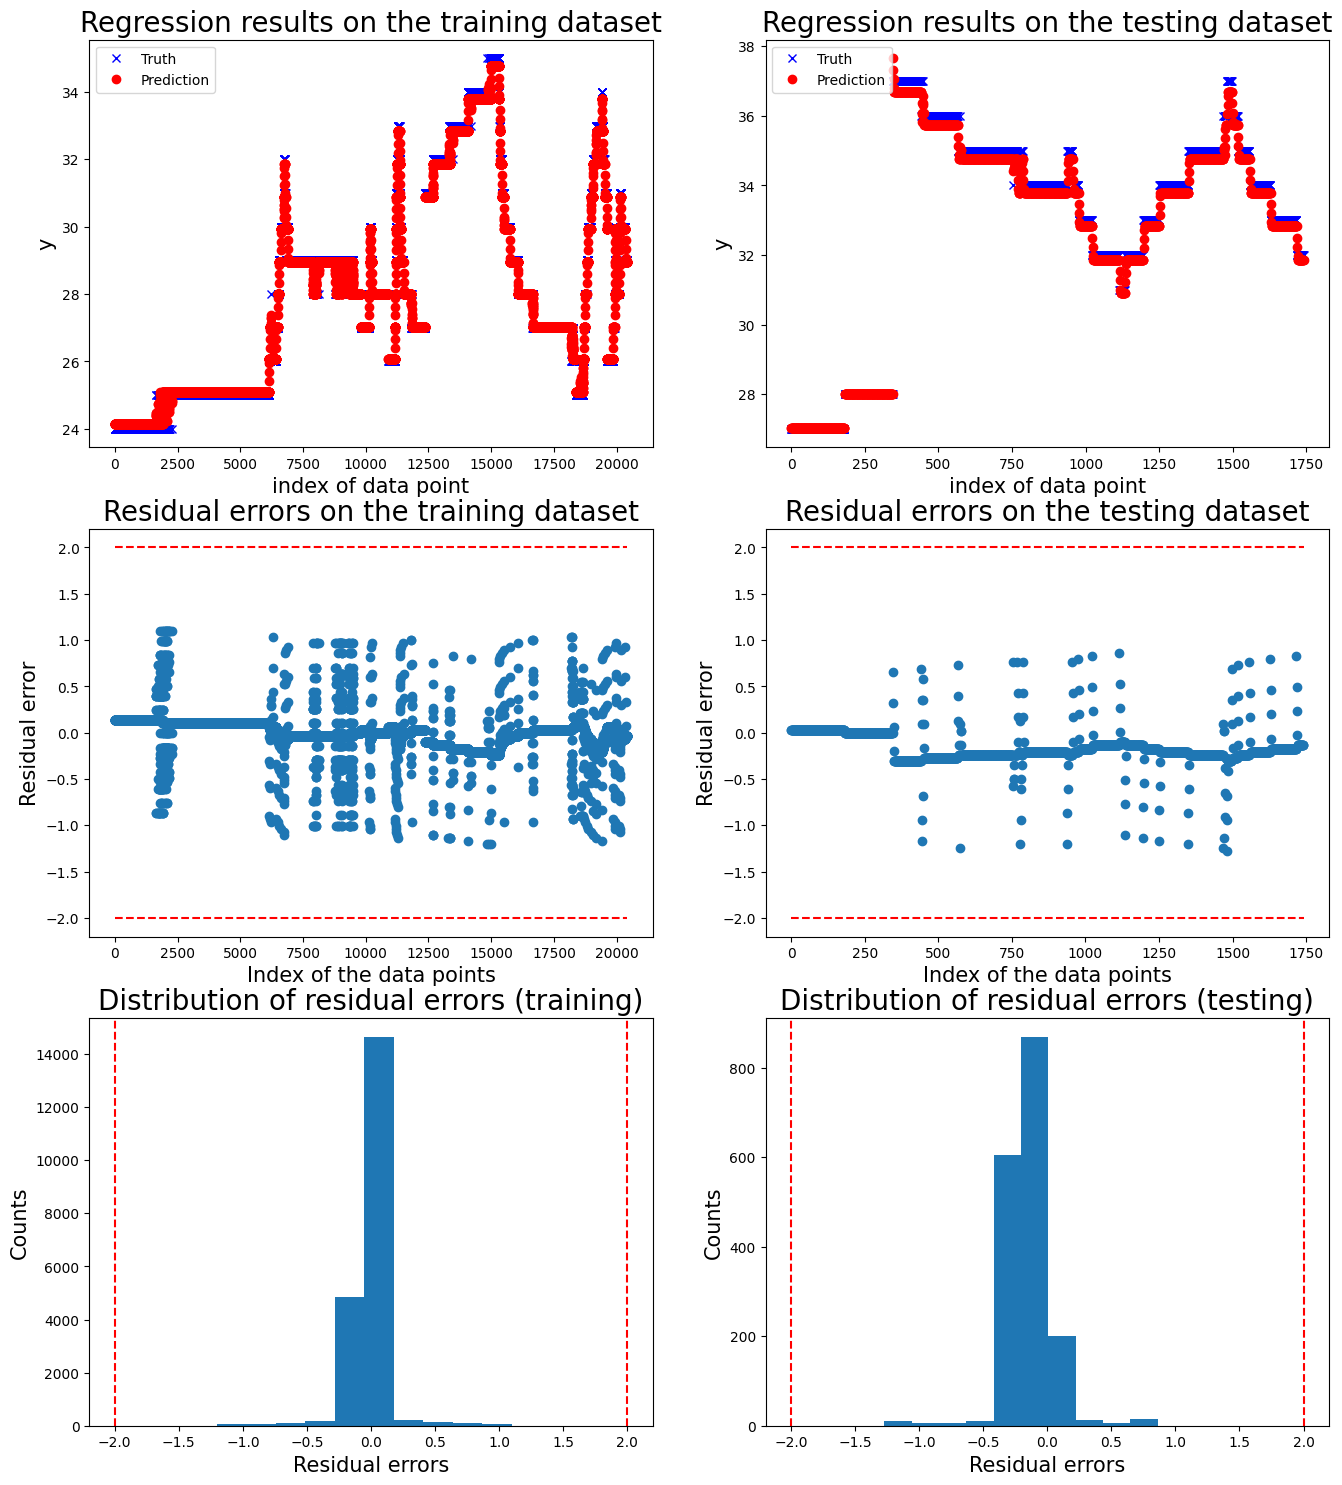

   Max error      RMSE  Exceed boundary rate
0   1.167726  0.215500                   0.0
1   1.019704  0.102741                   0.0
2   1.225063  0.176582                   0.0
3   1.051524  0.157901                   0.0
4   1.273840  0.244032                   0.0


Mean performance metric and standard error:
Max error: 1.1476 +- 0.1095
RMSE: 0.1794 +- 0.0544
Exceed boundary rate: 0.0000 +- 0.0000




In [15]:
steps2 = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', Lasso(alpha=0.1))    # Step 2: Lasso Regression
]

# Create the pipeline
mdl_lasso = Pipeline(steps2)

df_perf = run_cv_one_motor(motor_idx=6, df_data=df_data_smoothing, mdl=mdl_lasso, 
            feature_list=feature_list_all, n_fold=5, 
            threshold=threshold, window_size=window_size, sample_step=sample_step, mdl_type='reg')

## Logistic Regression 

In [6]:
new_feature_list = [ 'data_motor_1_temperature','data_motor_1_position',
                    'data_motor_2_temperature', 
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position',
                    'data_motor_6_temperature']

we'll first try with all the features

In [7]:
from sklearn.linear_model import LogisticRegression
steps3 = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LogisticRegression())    # Step 2: Logistic Regression
]

# Create the pipeline
mdl_logistic = Pipeline(steps3)

df_perf = run_cv_one_motor(motor_idx=6, df_data=df_data_smoothing, mdl=mdl_logistic, 
            feature_list=feature_list_all, n_fold=5, 
            threshold=threshold, window_size=window_size, sample_step=sample_step, mdl_type='reg',single_run_result=False)

Model for motor 6:


c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO.

   Max error      RMSE  Exceed boundary rate
0        8.0  3.886644              0.465192
1        5.0  2.058839              0.167263
2       11.0  5.895770              0.597847
3        9.0  3.274544              0.170398
4       12.0  6.301875              0.606959


Mean performance metric and standard error:
Max error: 9.0000 +- 2.7386
RMSE: 4.2835 +- 1.7887
Exceed boundary rate: 0.4015 +- 0.2197




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


we'll now try to select some features

In [9]:
from sklearn.linear_model import LogisticRegression
import warnings
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LogisticRegression())    # Step 2: Logistic Regression
]

# Create the pipeline
mdl_regreession = Pipeline(steps)

df_perf = run_cv_one_motor(motor_idx=6, df_data=df_data_smoothing, mdl=mdl_regreession, 
            feature_list=new_feature_list, n_fold=5, 
            threshold=threshold, window_size=window_size, sample_step=sample_step, mdl_type='reg',single_run_result=False)
#warnings.filterwarnings('ignore')


Model for motor 6:


c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO.

   Max error      RMSE  Exceed boundary rate
0        8.0  4.372708              0.517378
1        5.0  2.366470              0.280859
2       11.0  6.337271              0.853773
3        9.0  4.922029              0.399254
4       13.0  8.440558              0.798060


Mean performance metric and standard error:
Max error: 9.2000 +- 3.0332
RMSE: 5.2878 +- 2.2664
Exceed boundary rate: 0.5699 +- 0.2490




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


the result is worse

**Summary of the results - Only using features from the current moment**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| SVM |   6.25  |   3.23   |  51.56% | 
| Lasso  |  8.14   |   4.22   |  71.31% | 
| Logistic regression|   9  |   4.28   |  40.15% | 

For all the models we used threshold = 2 and we used all features because when we tried to remove some of them, the results were worse. We also smoothed the data because it gives us better results.

## Sub-task 2: Include the features in the past

Now, let's consider using the sliding window approach to include the past in the regression model as well. Please have a look at the demo notebook, run your experiment, and report the best models you could have if you apply the sliding window approach.

### Logistic regression

In [13]:
from utility import run_cv_one_motor

threshold = 2
window_size = 5
sample_step = 1
prediction_lead_time=1
for i in range(2,20,3) :
    print('window size = ',i)
    run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_logistic, feature_list=feature_list_all,
                n_fold=5, threshold=threshold, window_size=i, sample_step=sample_step,
            prediction_lead_time=prediction_lead_time, single_run_result=False, mdl_type='reg')

window size =  2
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0        3.0  2.140674              0.230730
1        6.0  2.764282              0.459193
2        9.0  3.060482              0.436312
3        7.0  2.901418              0.132335
4        7.0  1.935532              0.161714


Mean performance metric and standard error:
Max error: 6.4000 +- 2.1909
RMSE: 2.5605 +- 0.4936
Exceed boundary rate: 0.2841 +- 0.1539


window size =  5
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0        6.0  2.147937              0.263394
1        9.0  3.072953              0.596745
2        9.0  3.874301              0.533884
3        7.0  2.600505              0.093434
4        7.0  2.237609              0.190695


Mean performance metric and standard error:
Max error: 7.6000 +- 1.3416
RMSE: 2.7867 +- 0.7087
Exceed boundary rate: 0.3356 +- 0.2193


window size =  8
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0        3.0  2.182225         

The metrics don't change much for window size > 5. Let's see window sizes from 2 to 5

### Lasso regression

In [20]:
threshold = 2
#window_size = 5
sample_step = 1
prediction_lead_time=1
for i in range(2,6,1) :
    print('window size = ',i)
    run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_lasso, feature_list=feature_list_all,
                n_fold=5, threshold=threshold, window_size=i, sample_step=sample_step,
            prediction_lead_time=prediction_lead_time, single_run_result=False, mdl_type='reg')

window size =  2
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   1.168584  0.236064                   0.0
1   1.020192  0.082120                   0.0
2   1.229220  0.186068                   0.0
3   1.052488  0.125990                   0.0
4   1.281786  0.240795                   0.0


Mean performance metric and standard error:
Max error: 1.1505 +- 0.1122
RMSE: 0.1742 +- 0.0693
Exceed boundary rate: 0.0000 +- 0.0000


window size =  3
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   1.167699  0.221731                   0.0
1   1.019887  0.089778                   0.0
2   1.226079  0.177868                   0.0
3   1.051812  0.136876                   0.0
4   1.276955  0.238876                   0.0


Mean performance metric and standard error:
Max error: 1.1485 +- 0.1104
RMSE: 0.1730 +- 0.0612
Exceed boundary rate: 0.0000 +- 0.0000


window size =  4
Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   1.167656  0.216619         

The metrics are the best for window size in [3,5] so we will keep window size = 4

Let's see the difference between smoothed and raw data

## Linear regression

### raw data 

In [22]:
steps4 = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Lasso Regression
]

# Create the pipeline
mdl_linear = Pipeline(steps4)

threshold = 2
window_size = 4
sample_step = 1
prediction_lead_time=1

run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_linear, feature_list=feature_list_all,
                n_fold=5, threshold=threshold, window_size=window_size, sample_step=sample_step,
            prediction_lead_time=prediction_lead_time, single_run_result=False, mdl_type='reg')

Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   1.012590  0.165130                   0.0
1   1.037808  0.088748                   0.0
2   1.051375  0.121729                   0.0
3   1.017138  0.133091                   0.0
4   1.073769  0.147068                   0.0


Mean performance metric and standard error:
Max error: 1.0385 +- 0.0252
RMSE: 0.1312 +- 0.0287
Exceed boundary rate: 0.0000 +- 0.0000




Max error      RMSE  Exceed boundary rate
0   1.012590  0.165130                   0.0
1   1.037808  0.088748                   0.0
2   1.051375  0.121729                   0.0
3   1.017138  0.133091                   0.0
4   1.073769  0.147068                   0.0

### smoothed data

In [24]:
threshold = 2
window_size = 4
sample_step = 1
prediction_lead_time=1

run_cv_one_motor(motor_idx=6, df_data=df_data_smoothing, mdl=mdl_linear, feature_list=feature_list_all,
                n_fold=5, threshold=threshold, window_size=window_size, sample_step=sample_step,
            prediction_lead_time=prediction_lead_time, single_run_result=False, mdl_type='reg')

Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   1.020190  0.165370                   0.0
1   1.058387  0.088833                   0.0
2   1.049000  0.121278                   0.0
3   1.017691  0.132781                   0.0
4   1.037015  0.146407                   0.0


Mean performance metric and standard error:
Max error: 1.0365 +- 0.0177
RMSE: 0.1309 +- 0.0287
Exceed boundary rate: 0.0000 +- 0.0000




Max error      RMSE  Exceed boundary rate
0   1.020190  0.165370                   0.0
1   1.058387  0.088833                   0.0
2   1.049000  0.121278                   0.0
3   1.017691  0.132781                   0.0
4   1.037015  0.146407                   0.0

The metrics are a little bit better

In [25]:
threshold = 2
window_size = 4
sample_step = 1
prediction_lead_time=1

run_cv_one_motor(motor_idx=6, df_data=df_data_smoothing, mdl=mdl_SVM, feature_list=feature_list_all,
                n_fold=5, threshold=threshold, window_size=window_size, sample_step=sample_step,
            prediction_lead_time=prediction_lead_time, single_run_result=False, mdl_type='reg')

Model for motor 6:
   Max error      RMSE  Exceed boundary rate
0   4.041168  1.405997              0.175984
1   2.128177  0.394896              0.001803
2   6.817605  3.021019              0.437758
3   2.321101  1.338302              0.017610
4   6.629925  3.122849              0.728211


Mean performance metric and standard error:
Max error: 4.3876 +- 2.2599
RMSE: 1.8566 +- 1.1798
Exceed boundary rate: 0.2723 +- 0.3093




Max error      RMSE  Exceed boundary rate
0   4.041168  1.405997              0.175984
1   2.128177  0.394896              0.001803
2   6.817605  3.021019              0.437758
3   2.321101  1.338302              0.017610
4   6.629925  3.122849              0.728211

To conclude, we keep threshold = 2 , window_size = 4 , prediction_lead_time = 1 (to predict only one step) and the sample step = 1.

**Summary of the results - Sliding window**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   (also report parameters like window_size, sample_step, prediction_lead_time, etc.) | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| Logistic Regression |  6.4  |  2.56   | 28% | 
| Lasso regression |  1.15%  |   0.18   |  0% | 
| Linear regression |   1.04  |   0.13   |  0% | 
| SVM |   4.39 |   1.86   |  27.23% | 

The best model is then the Linear Regression model. We could improve it with feature selection.

# Task 2 Fault detection based on regression model

In this exercise, we use the dataset that contains the failure of motor 6 to test the fault detection model based on the regression model trained before. 

[This notebook](demo_FaultDetectReg.ipynb) presents a demonstration of how to use the provided supporting function to develop fault detection model based on the regression model. Please have a look at this notebook, and try to improve the performance of the baseline model.

Model for motor 6:


100%|██████████| 1/1 [00:07<00:00,  7.11s/it]



 New run:

testing performance, max error is: 2.666812092629928
testing performance, mean root square error is: 0.5488215974620223
testing performance, residual error > 1.465940458627319: 6.080674292594822%

 New run:

testing performance, accuracy is: 0.964328717639976
testing performance, precision is: 0.9483568075117371
testing performance, recall: 0.6526655896607432
testing performance, F1: 0.7732057416267942




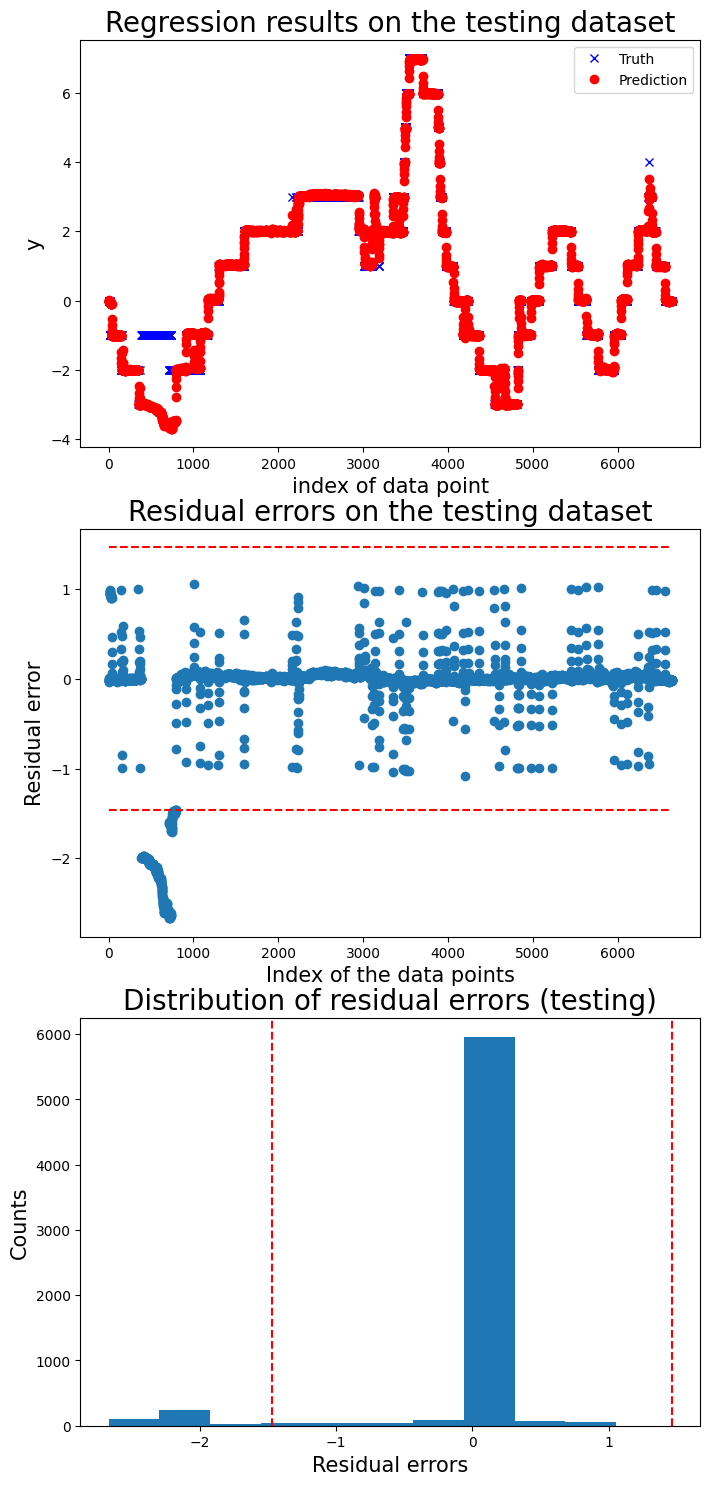

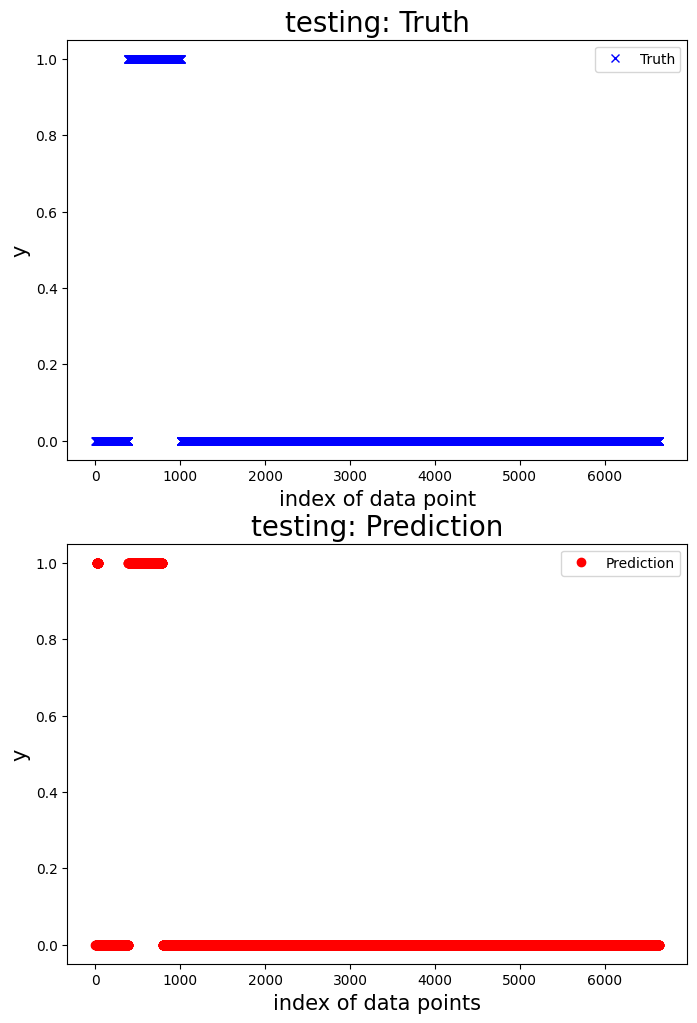

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



 New run:

testing performance, max error is: 3.9184912309480264
testing performance, mean root square error is: 1.5487701939962792
testing performance, residual error > 0.9: 42.600896860986545%

 New run:

testing performance, accuracy is: 0.8699551569506726
testing performance, precision is: 0.7789473684210526
testing performance, recall: 0.9024390243902439
testing performance, F1: 0.8361581920903954




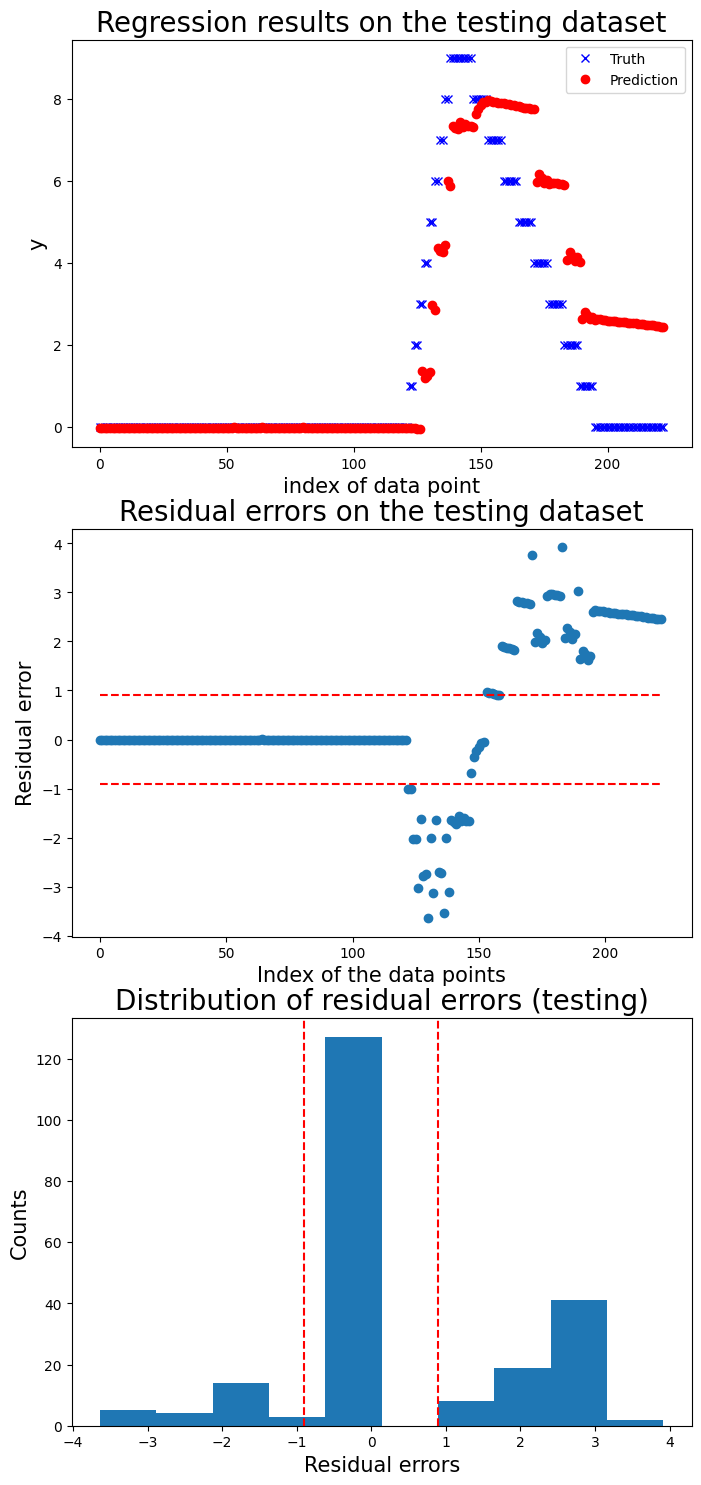

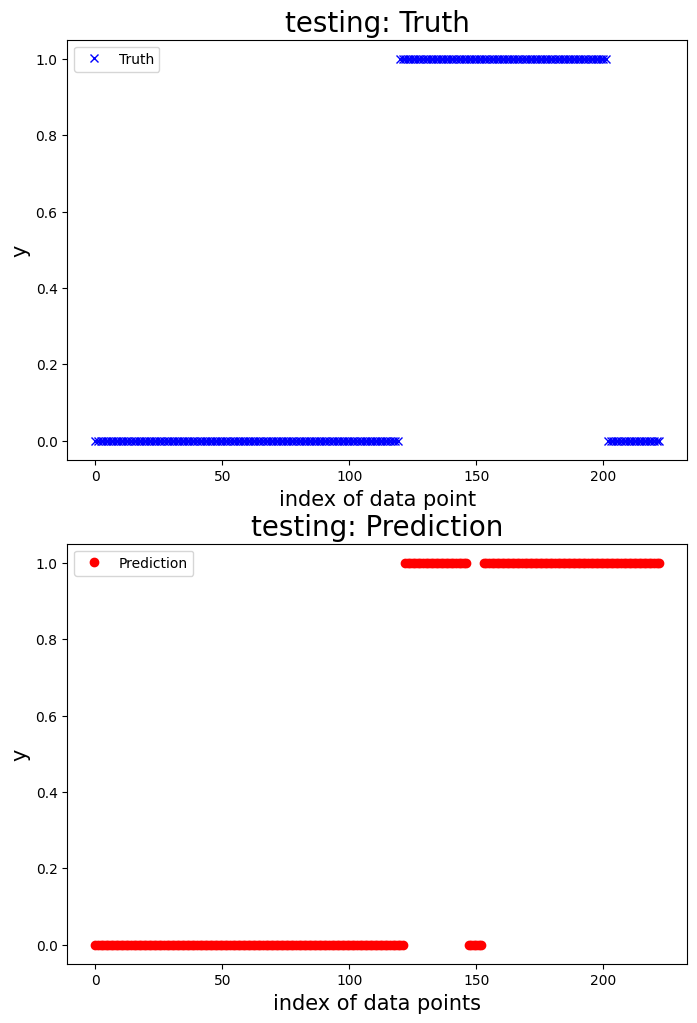

100%|██████████| 1/1 [00:00<00:00,  2.52it/s]



 New run:

testing performance, max error is: 3.030254892280338
testing performance, mean root square error is: 0.5501669046278164
testing performance, residual error > 0.9: 19.746376811594203%

 New run:

testing performance, accuracy is: 0.8804347826086957
testing performance, precision is: 0.7889908256880734
testing performance, recall: 0.6666666666666666
testing performance, F1: 0.7226890756302521




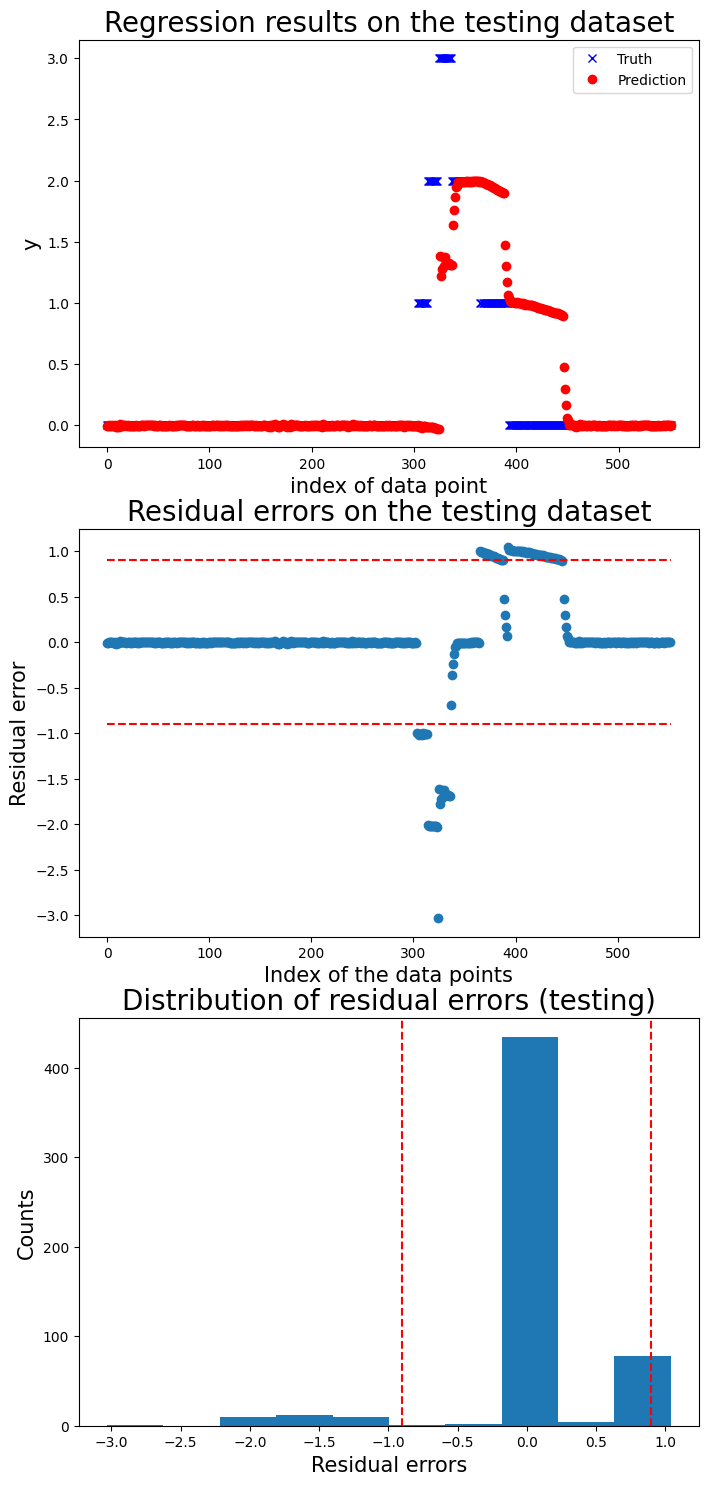

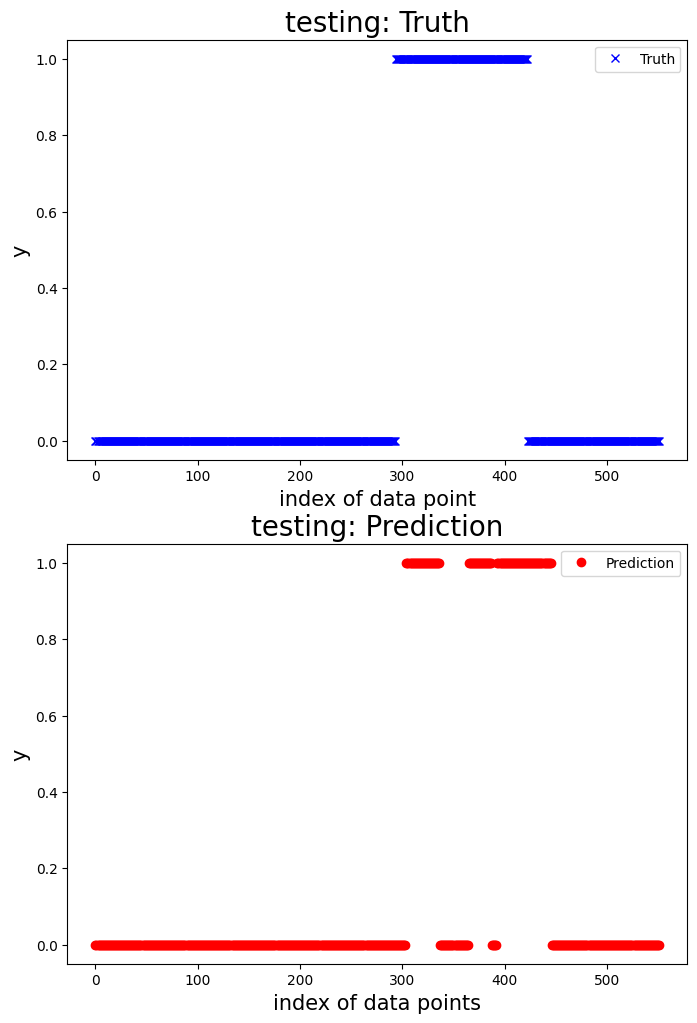

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]



 New run:

testing performance, max error is: 2.039133035376194
testing performance, mean root square error is: 0.2409956100694684
testing performance, residual error > 0.9: 3.3783783783783785%

 New run:

testing performance, accuracy is: 0.972972972972973
testing performance, precision is: 1.0
testing performance, recall: 0.5555555555555556
testing performance, F1: 0.7142857142857143




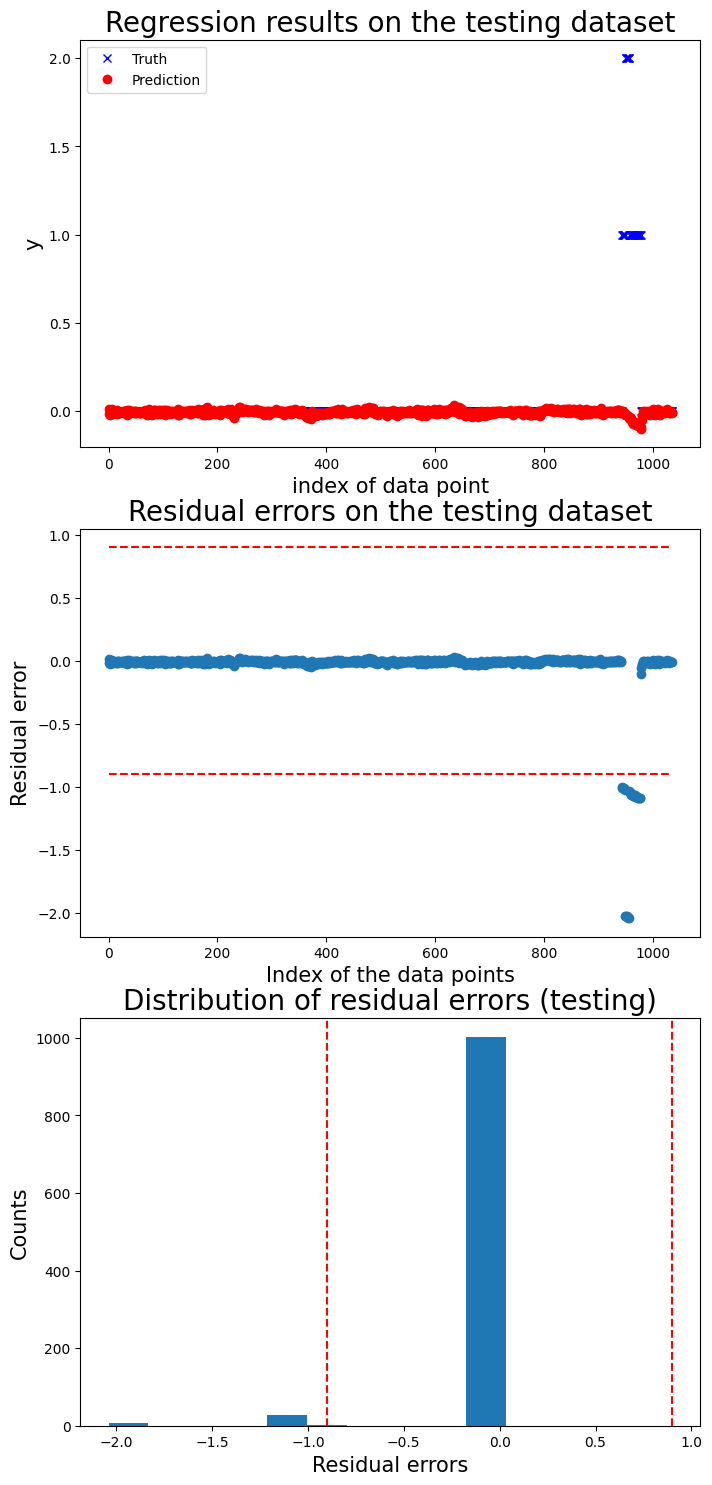

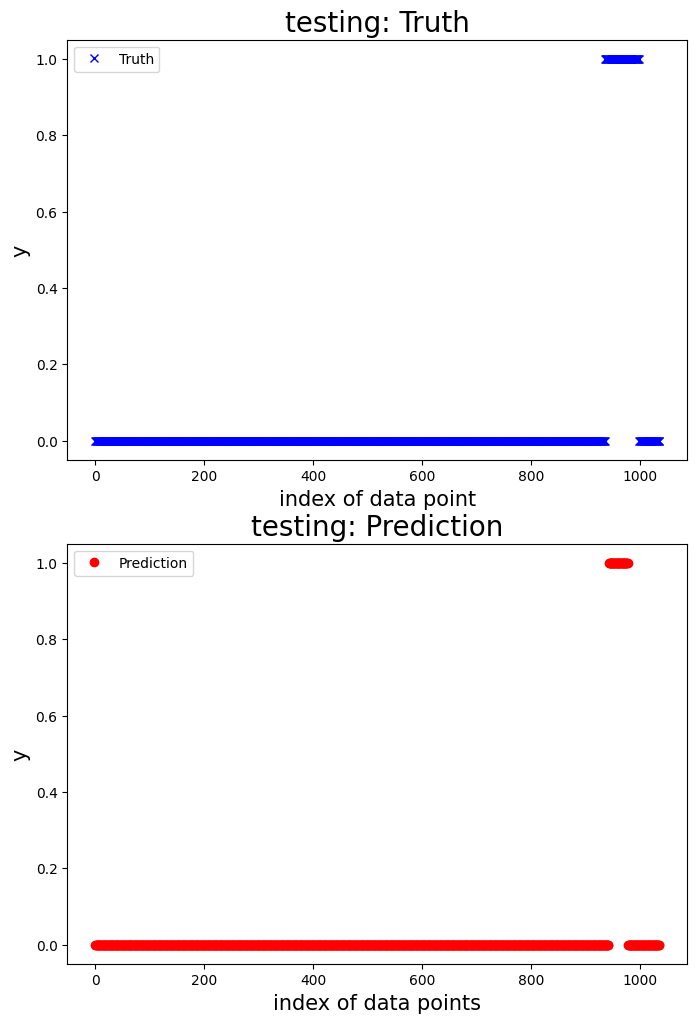

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]



 New run:

testing performance, max error is: 3.985659452069802
testing performance, mean root square error is: 1.2302538644880407
testing performance, residual error > 0.9: 43.821209465381244%

 New run:

testing performance, accuracy is: 0.8098159509202454
testing performance, precision is: 0.63
testing performance, recall: 0.9077809798270894
testing performance, F1: 0.743801652892562




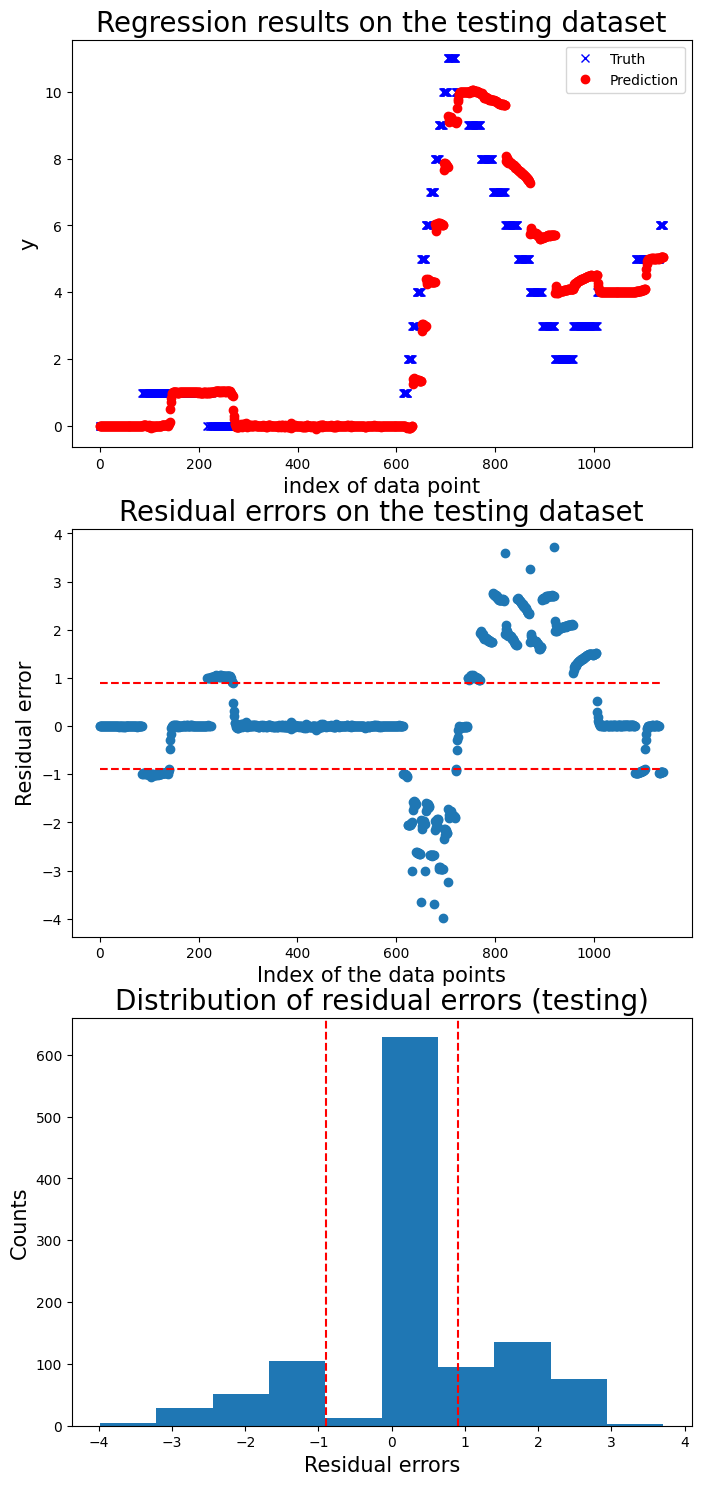

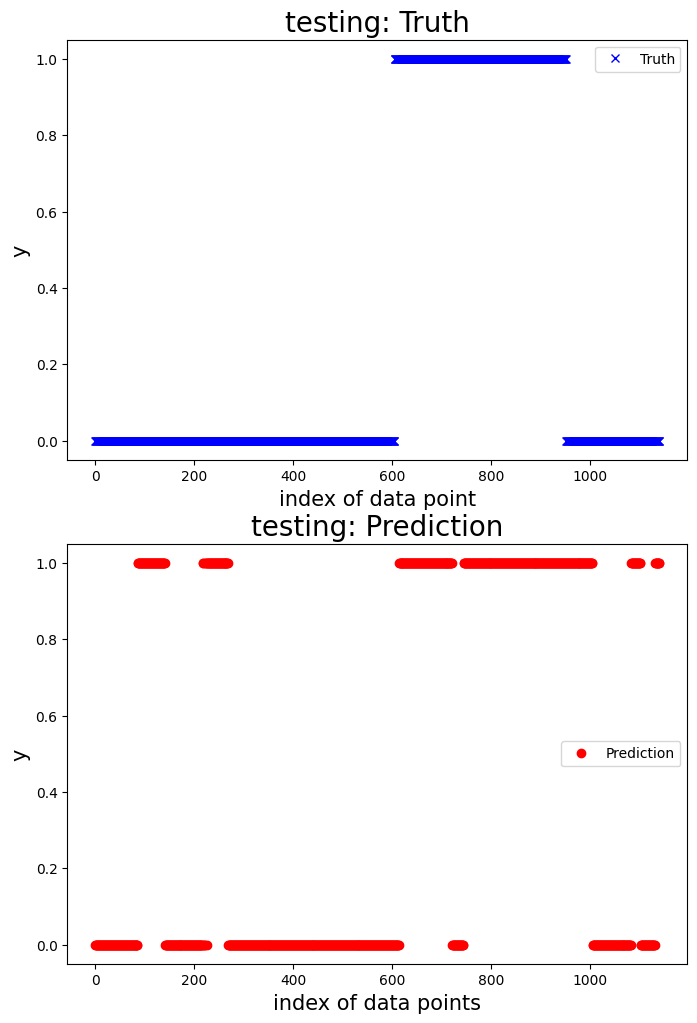

100%|██████████| 1/1 [00:00<00:00,  2.02it/s]



 New run:

testing performance, max error is: 3.990018485789685
testing performance, mean root square error is: 1.8425631334833676
testing performance, residual error > 0.9: 67.34348561759728%

 New run:

testing performance, accuracy is: 0.7969543147208121
testing performance, precision is: 0.9522613065326633
testing performance, recall: 0.7895833333333333
testing performance, F1: 0.8633257403189066




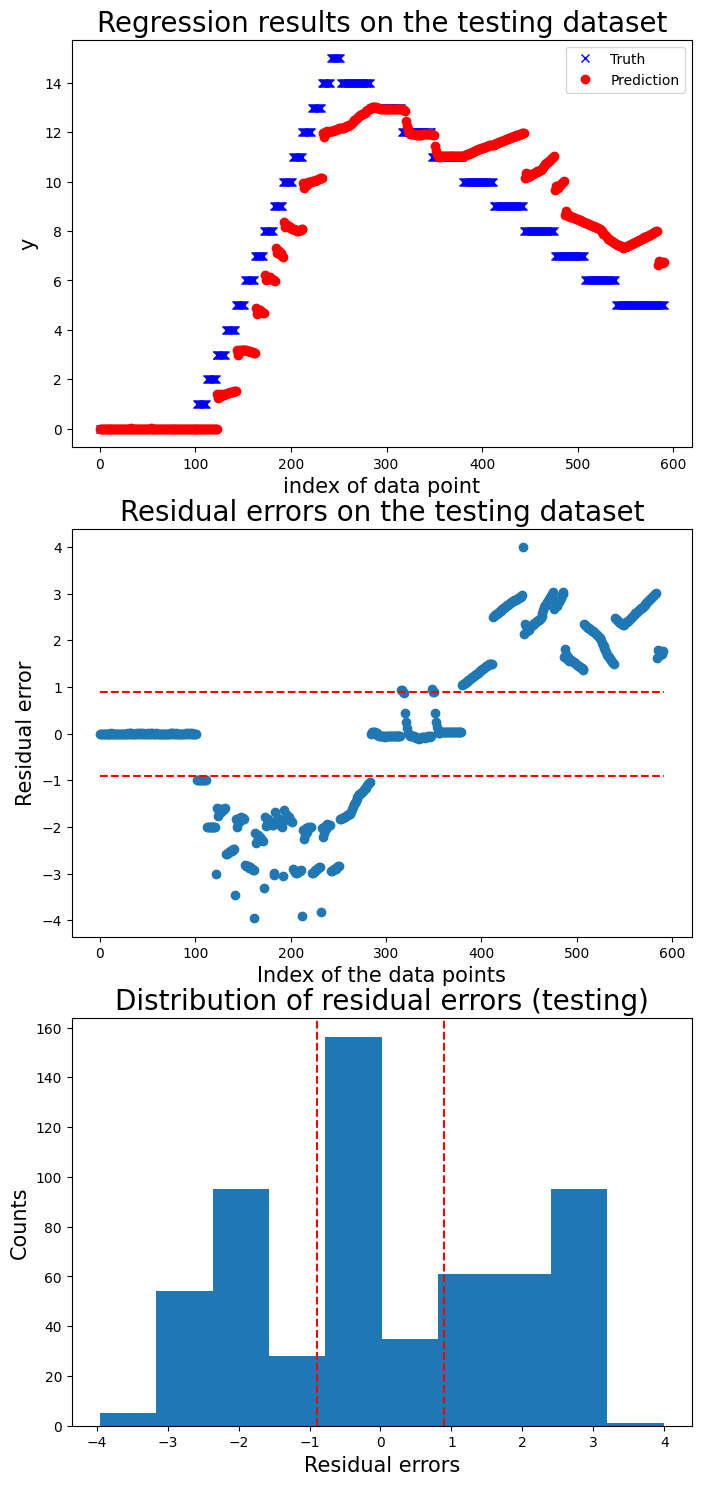

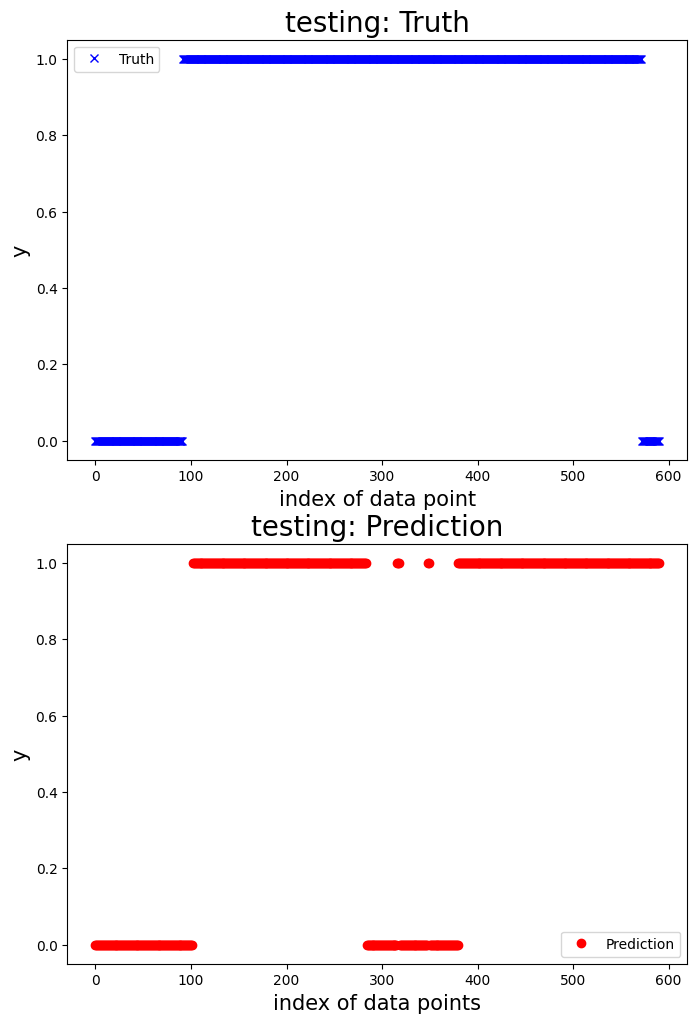

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]



 New run:

testing performance, max error is: 2.9656361360464274
testing performance, mean root square error is: 1.1753168287701727
testing performance, residual error > 1.3994130831935: 19.115734720416125%

 New run:

testing performance, accuracy is: 0.5240572171651495
testing performance, precision is: 0.15
testing performance, recall: 0.15566037735849056
testing performance, F1: 0.1527777777777778




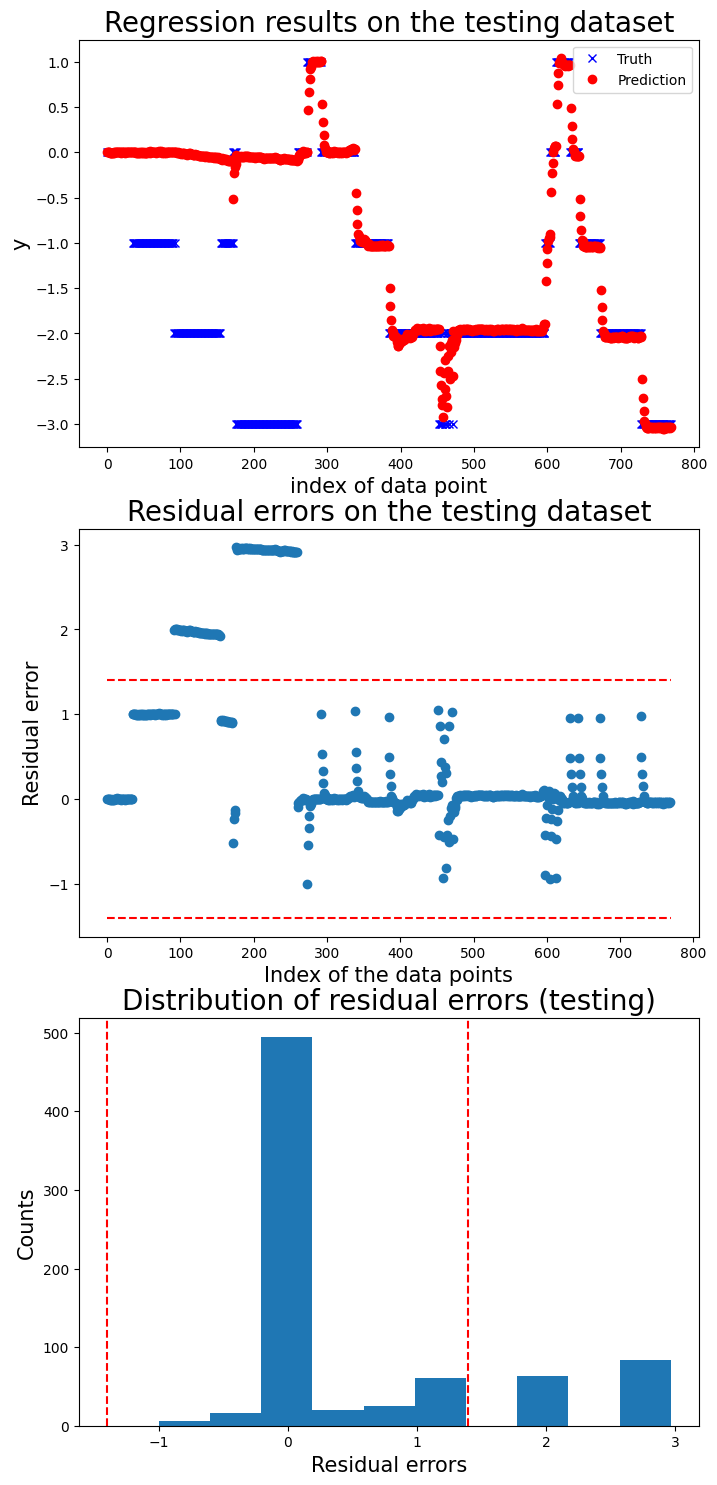

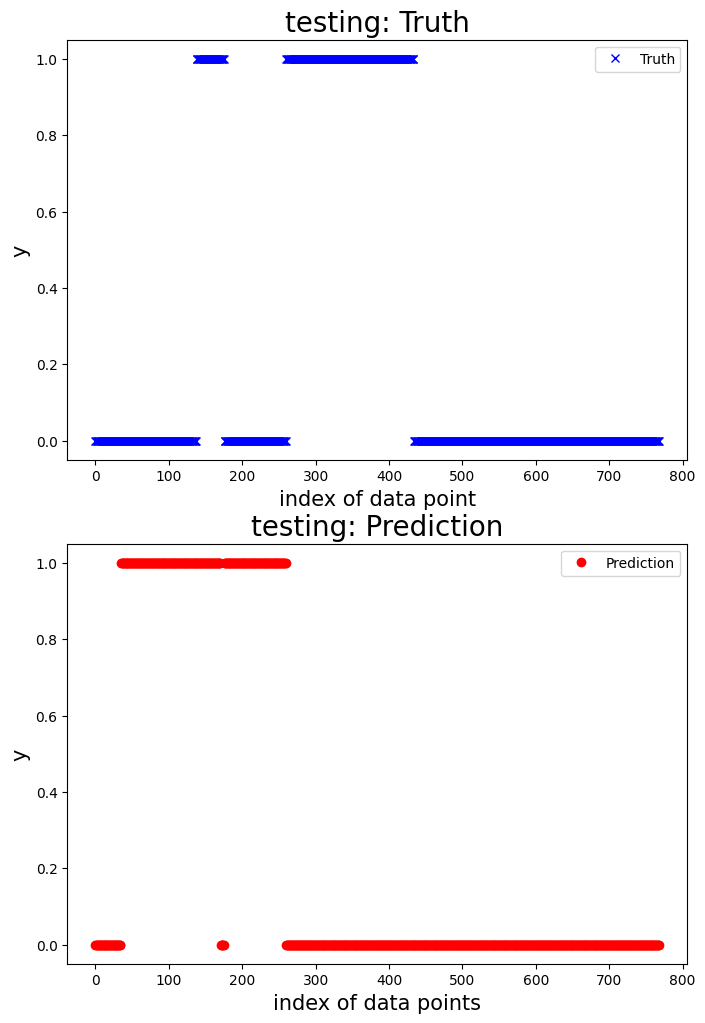

   Accuracy  Precision    Recall  F1 score
0  0.964329   0.948357  0.652666  0.773206
1  0.869955   0.778947  0.902439  0.836158
2  0.880435   0.788991  0.666667  0.722689
3  0.972973   1.000000  0.555556  0.714286
4  0.809816   0.630000  0.907781  0.743802
5  0.796954   0.952261  0.789583  0.863326
6  0.524057   0.150000  0.155660  0.152778


Mean performance metric and standard error:
Accuracy: 0.8312 +- 0.1515
Precision: 0.7498 +- 0.2943
Recall: 0.6615 +- 0.2589
F1 score: 0.6866 +- 0.2420




In [62]:
# Test the class FaultDetectReg

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from utility import read_all_test_data_from_path, extract_selected_feature, prepare_sliding_window, FaultDetectReg


def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = df['position'] - df['position'].iloc[0]


# Read data.
#base_dictionary = 'C:/Users/Zhiguo/OneDrive - CentraleSupelec/Code/Python/digital_twin_robot/projects/maintenance_industry_4_2024/dataset/training_data/'
base_dictionary='../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

# Pre-train the model.
# Get all the normal data.
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213',
    '20240325_152902', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']

df_tr = df_data[df_data['test_condition'].isin(normal_test_id)]

feature_list_all = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

# feature_list_all = ['time', 'data_motor_1_position', 
#                 'data_motor_2_position', 
#                 'data_motor_3_position', 
#                 'data_motor_4_position', 
#                 'data_motor_5_position', 
#                 'data_motor_6_position', 'data_motor_6_temperature']

# Prepare feature and response of the training dataset.
x_tr_org, y_temp_tr_org = extract_selected_feature(df_data=df_tr, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')

# Enrich the features based on the sliding window.
window_size = 9
sample_step = 1
prediction_lead_time = 1
threshold = 0.9
abnormal_limit = 3

x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr_org, y=y_temp_tr_org, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')

# Define the steps of the pipeline
steps = [
    ('standardizer', MinMaxScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)
# Fit the model
mdl = mdl_linear_regreession.fit(x_tr, y_temp_tr)

# Test data.
test_id = [
    '20240325_155003',
    '20240425_093699',
    '20240425_094425',
    '20240426_140055',
    '20240503_163963',
    '20240503_164675',
    '20240503_165189'
]
df_test = df_data[df_data['test_condition'].isin(test_id)]

# Define the fault detector.
detector_reg = FaultDetectReg(reg_mdl=mdl, threshold=threshold, abnormal_limit=abnormal_limit, window_size=window_size, sample_step=sample_step, pred_lead_time=prediction_lead_time)


# # Predict the temperature
# detector_reg.threshold = 1
# y_label_pred_tr, y_temp_pred_tr = detector_reg.predict(df_x_test=x_tr_org, y_response_test=y_temp_tr_org)
# y_label_pred_tmp, y_temp_pred_tmp = detector_reg.predict(df_x_test=x_test_org, y_response_test=y_temp_test_org)

# # Get the true values.
# _, y_label_test = prepare_sliding_window(df_x=x_test_org, y=y_label_test_org, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='clf')
# _, y_temp_test_seq = prepare_sliding_window(df_x=x_test_org, y=y_temp_test_org, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')


# show_reg_result(y_tr=y_temp_tr, y_test=y_temp_test_seq, y_pred_tr=y_temp_pred_tr, y_pred=y_temp_pred_tmp, threshold=detector_reg.threshold)
# show_clf_result(y_tr=np.zeros(len(y_label_pred_tr)), y_test=y_label_test, y_pred_tr=y_label_pred_tr, y_pred=y_label_pred_tmp)

# # Run cross validation
n_fold = 7
_, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='clf')
x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')

motor_idx = 6
print(f'Model for motor {motor_idx}:')
# Run cross validation.
df_perf = detector_reg.run_cross_val(df_x=x_test_org, y_label=y_label_test_org, y_response=y_temp_test_org, 
                                        n_fold=n_fold)
print(df_perf)
print('\n')
# Print the mean performance and standard error.
print('Mean performance metric and standard error:')
for name, metric, error in zip(df_perf.columns, df_perf.mean(), df_perf.std()):
    print(f'{name}: {metric:.4f} +- {error:.4f}') 
print('\n')

Model for motor 6:


100%|██████████| 1/1 [00:07<00:00,  7.55s/it]



 New run:

testing performance, max error is: 2.667647996690123
testing performance, mean root square error is: 0.5502009384328145
testing performance, residual error > 1.4623113123743827: 6.080674292594822%

 New run:

testing performance, accuracy is: 0.9623720650210716
testing performance, precision is: 0.9202733485193622
testing performance, recall: 0.6526655896607432
testing performance, F1: 0.7637051039697542




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


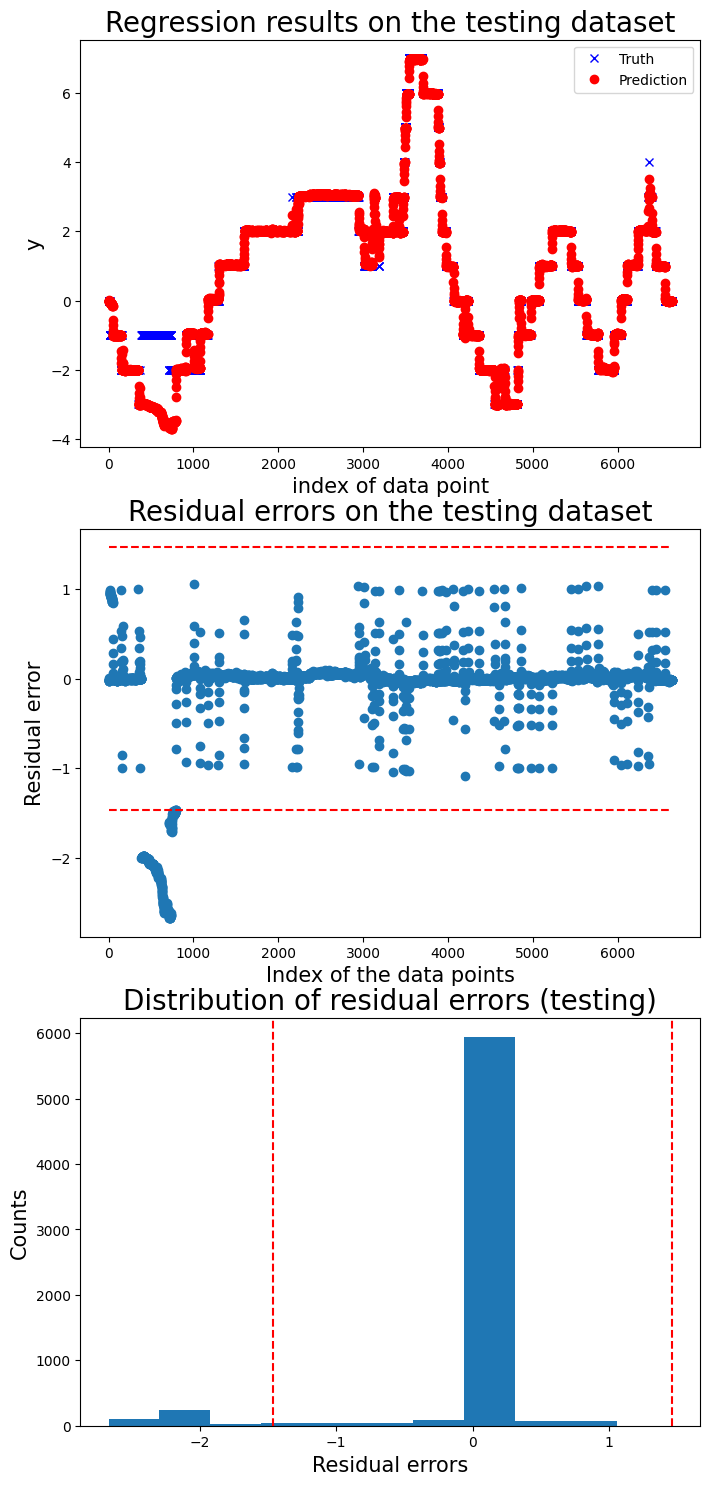

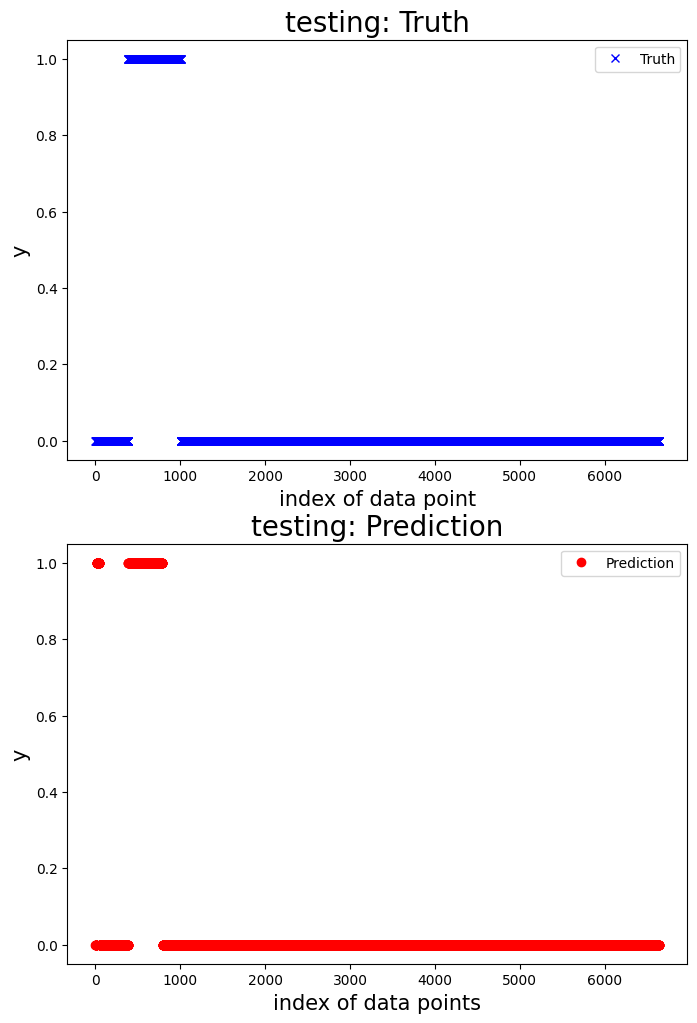

100%|██████████| 1/1 [00:00<00:00,  4.48it/s]



 New run:

testing performance, max error is: 4.317456230056973
testing performance, mean root square error is: 1.701639150643765
testing performance, residual error > 0.85: 42.600896860986545%

 New run:

testing performance, accuracy is: 0.8699551569506726
testing performance, precision is: 0.7789473684210526
testing performance, recall: 0.9024390243902439
testing performance, F1: 0.8361581920903954




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


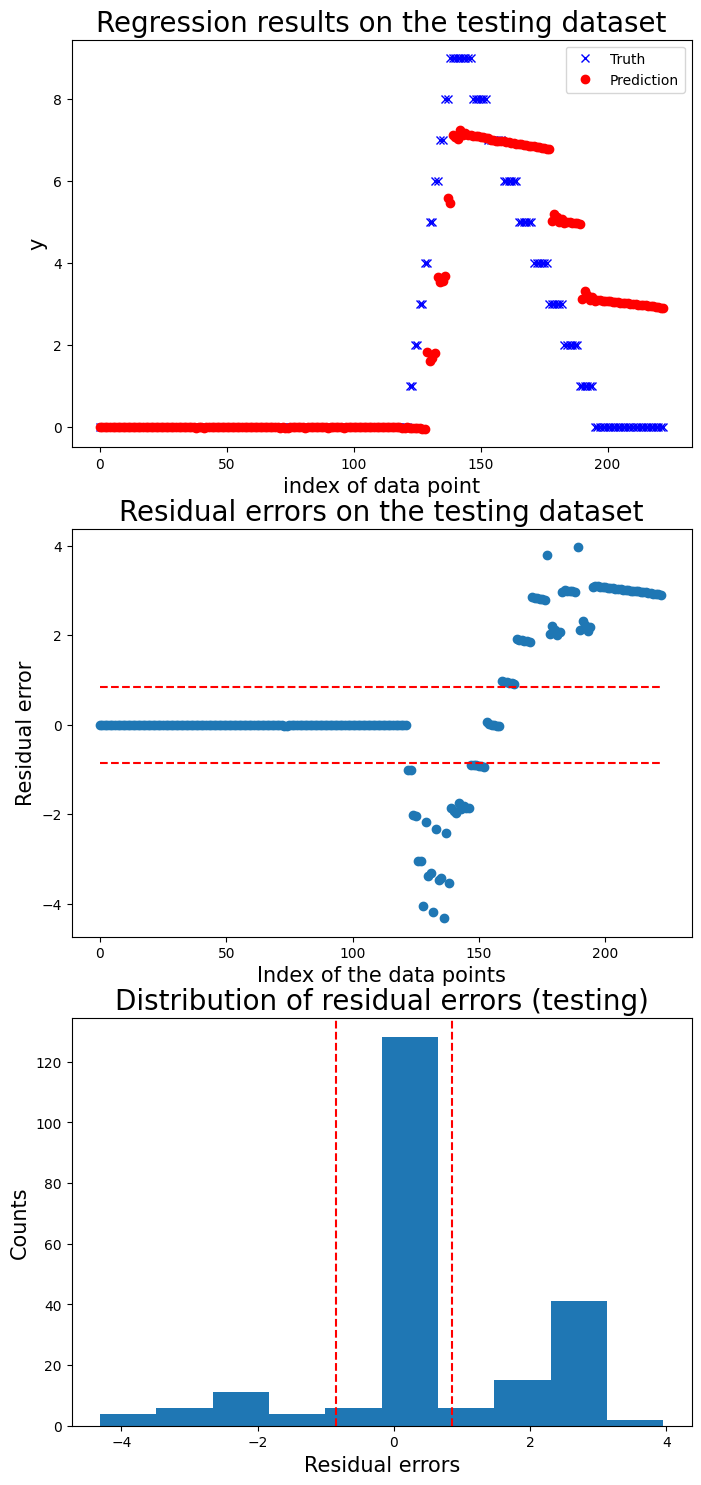

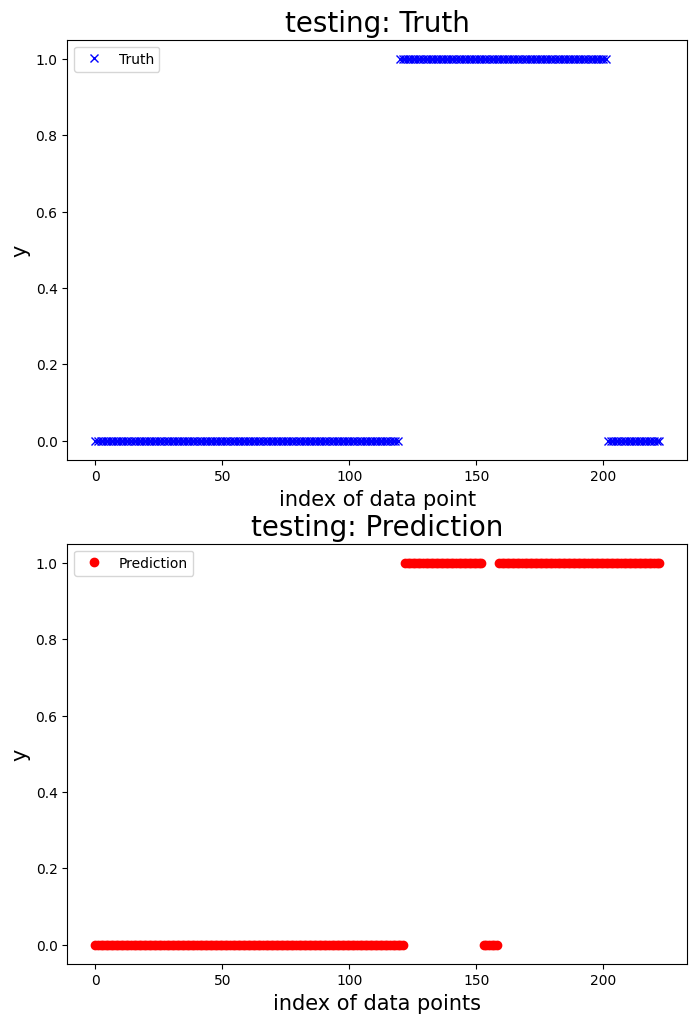

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]



 New run:

testing performance, max error is: 3.0622510071694142
testing performance, mean root square error is: 0.7726626601132984
testing performance, residual error > 0.85: 16.1231884057971%

 New run:

testing performance, accuracy is: 0.927536231884058
testing performance, precision is: 1.0
testing performance, recall: 0.689922480620155
testing performance, F1: 0.8165137614678899




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


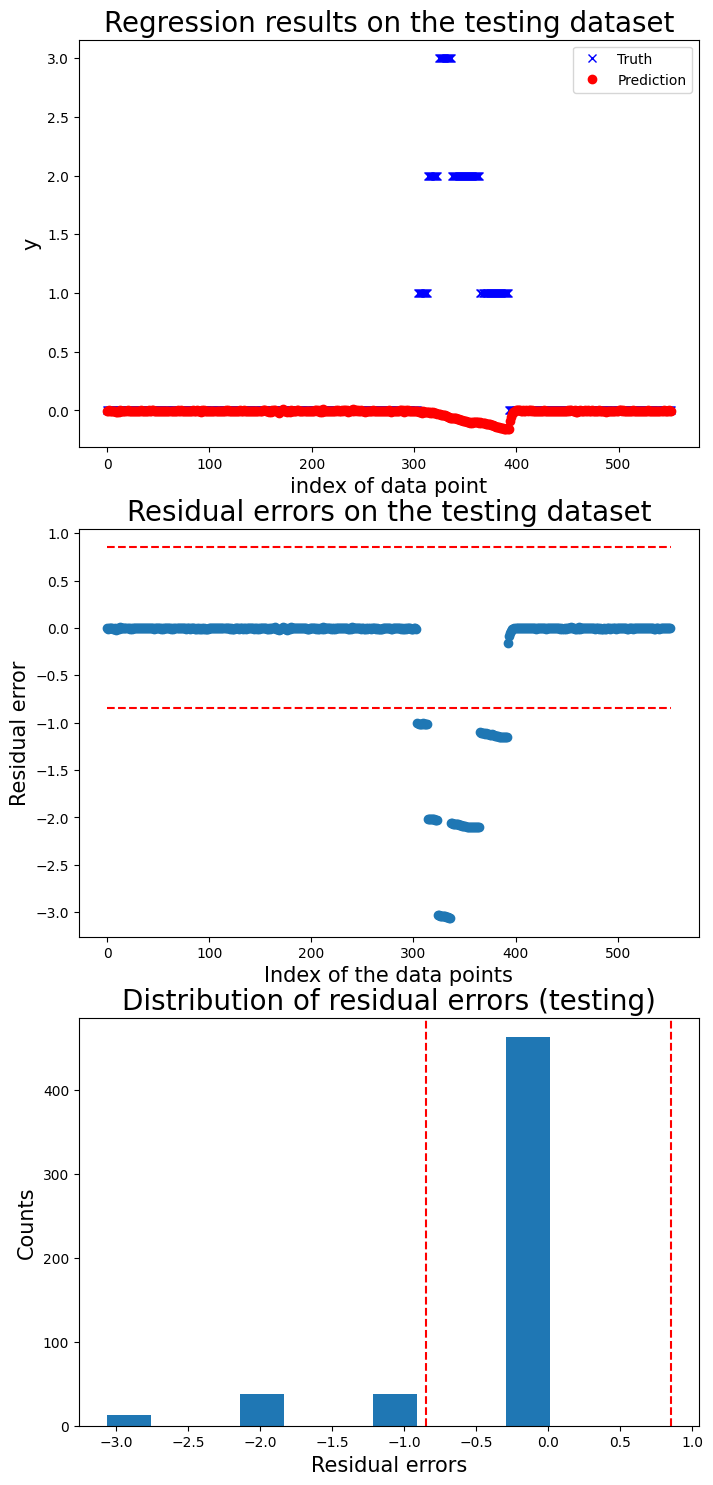

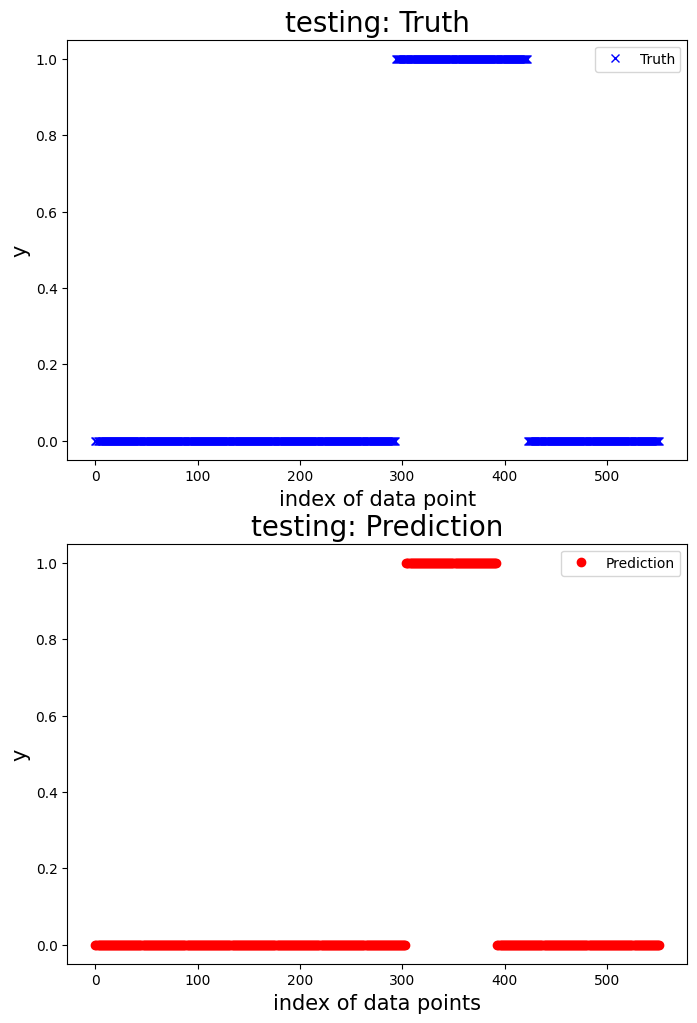

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]



 New run:

testing performance, max error is: 2.039168511034719
testing performance, mean root square error is: 0.24098210241661525
testing performance, residual error > 0.85: 3.3783783783783785%

 New run:

testing performance, accuracy is: 0.972972972972973
testing performance, precision is: 1.0
testing performance, recall: 0.5555555555555556
testing performance, F1: 0.7142857142857143




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


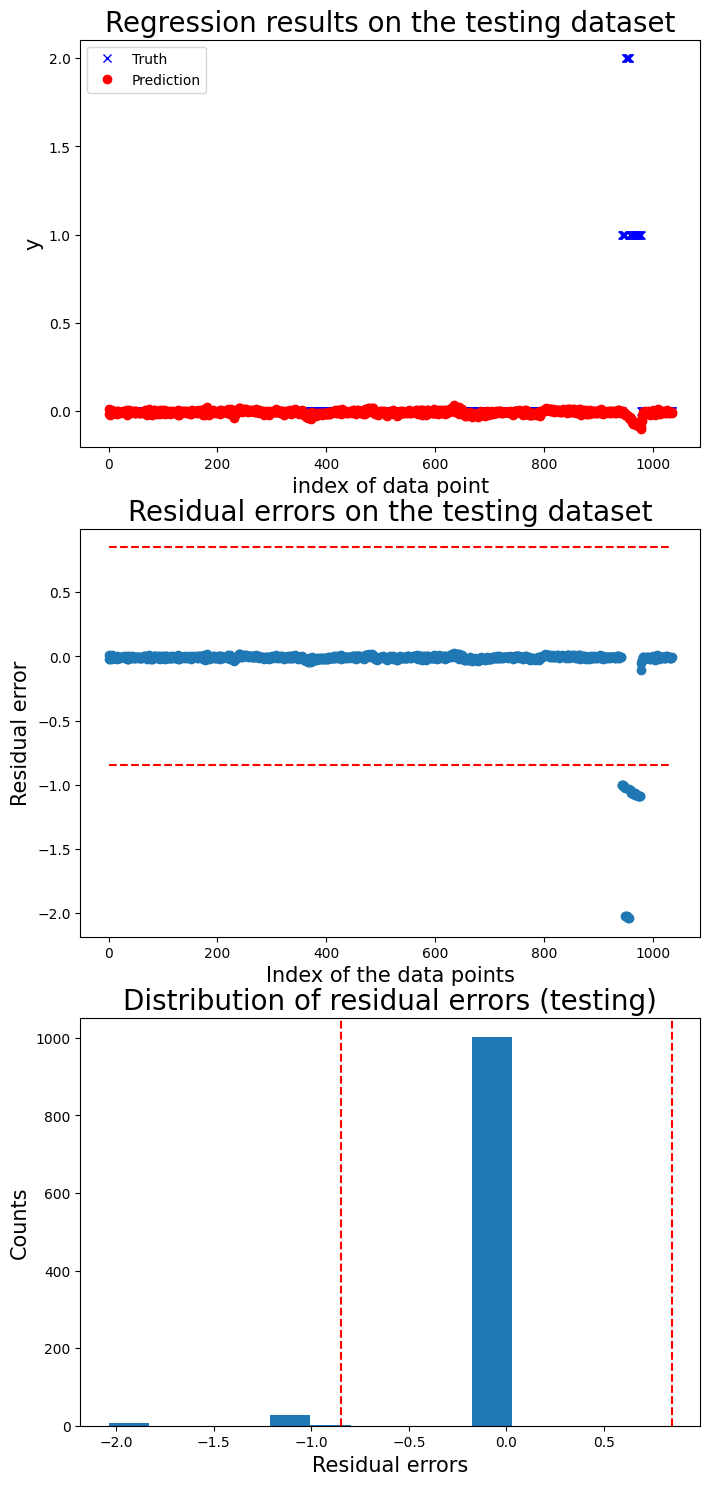

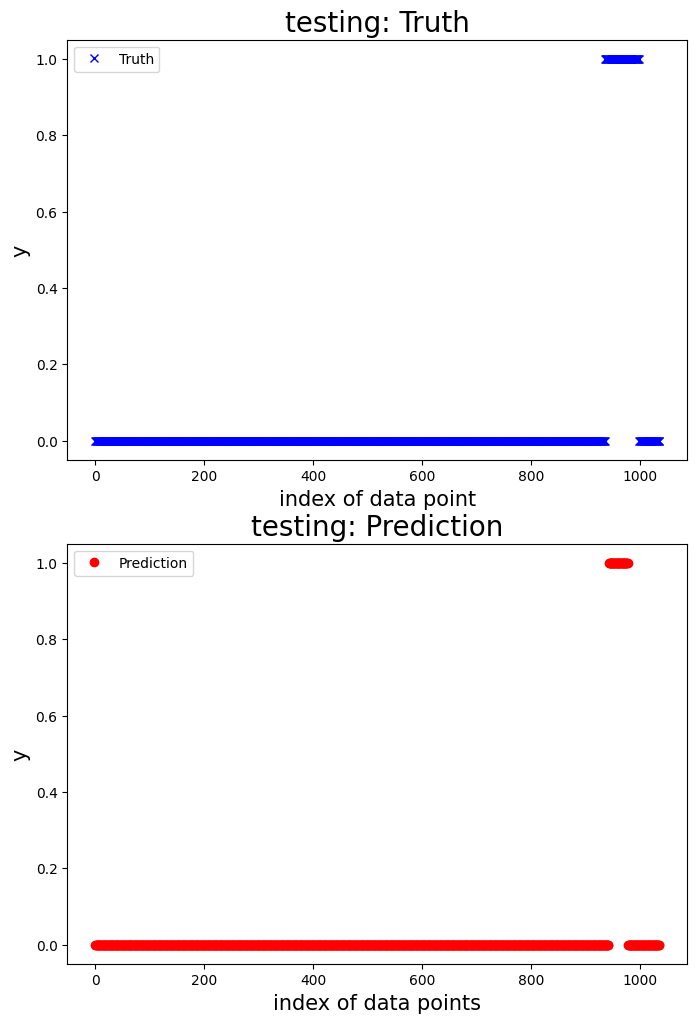

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]



 New run:

testing performance, max error is: 4.34963983253873
testing performance, mean root square error is: 1.5329550658151467
testing performance, residual error > 0.85: 52.84837861524978%

 New run:

testing performance, accuracy is: 0.6985100788781771
testing performance, precision is: 0.5024875621890548
testing performance, recall: 0.8731988472622478
testing performance, F1: 0.6378947368421053




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


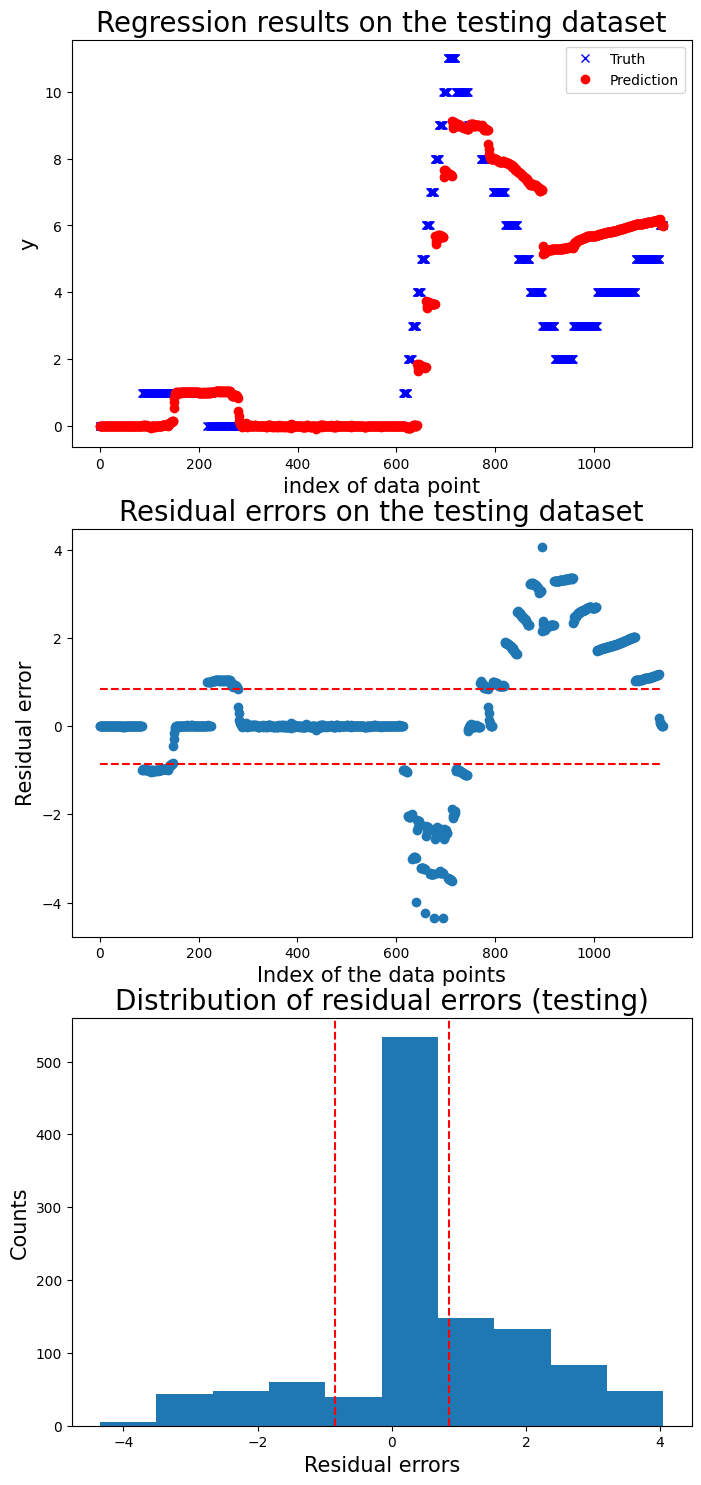

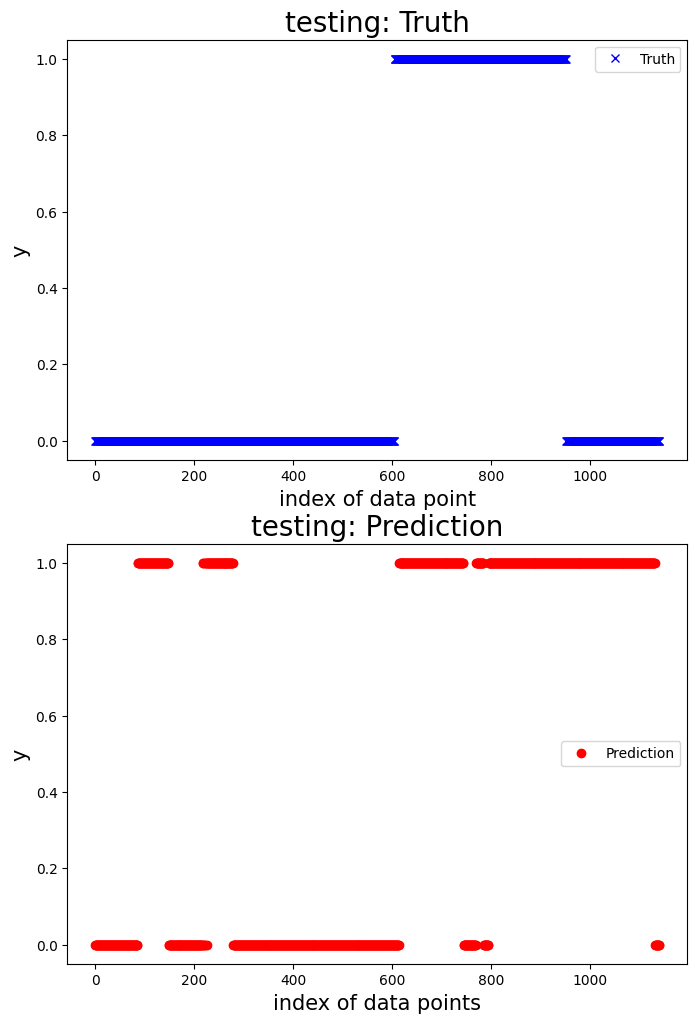

100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



 New run:

testing performance, max error is: 4.457249709991321
testing performance, mean root square error is: 2.072960090716897
testing performance, residual error > 0.85: 68.02030456852792%

 New run:

testing performance, accuracy is: 0.8037225042301185
testing performance, precision is: 0.9527363184079602
testing performance, recall: 0.7979166666666667
testing performance, F1: 0.8684807256235828




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


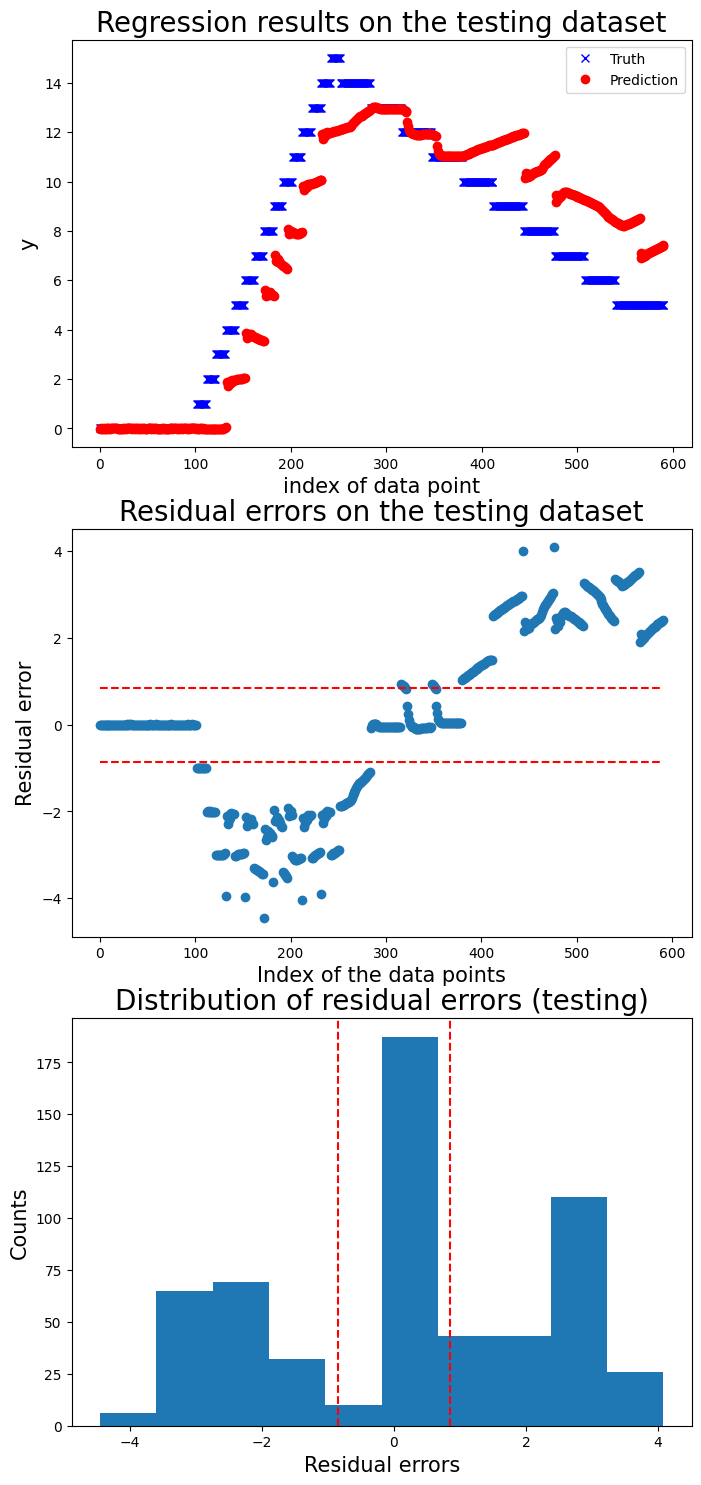

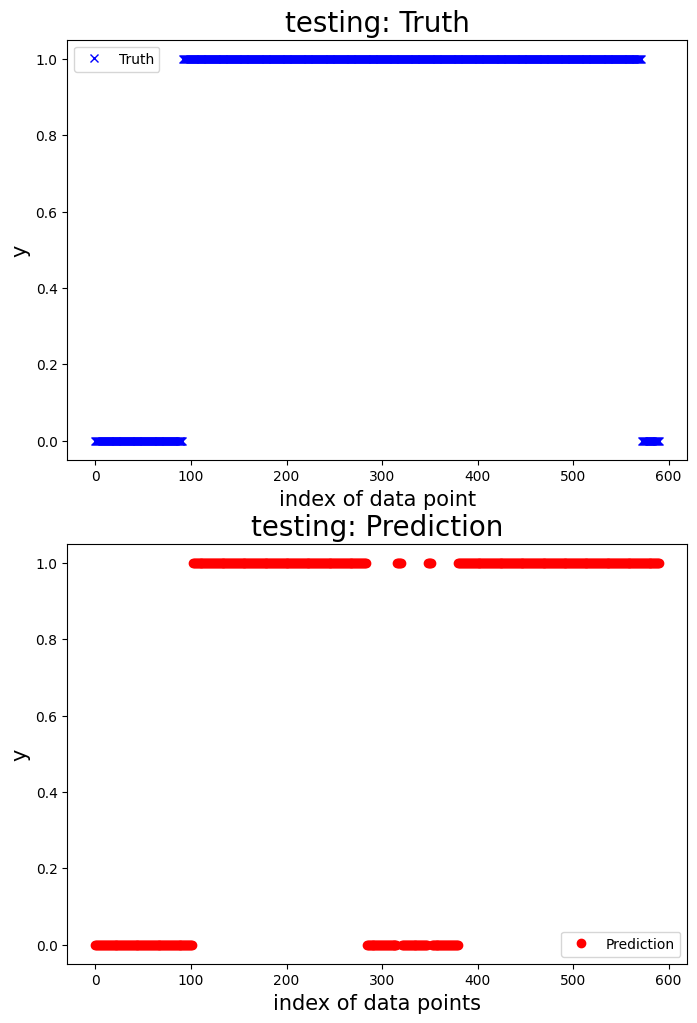

100%|██████████| 1/1 [00:00<00:00,  1.45it/s]



 New run:

testing performance, max error is: 2.9920705776174956
testing performance, mean root square error is: 1.2319016015541213
testing performance, residual error > 0.8786732707479589: 40.83224967490247%

 New run:

testing performance, accuracy is: 0.5565669700910273
testing performance, precision is: 0.30153846153846153
testing performance, recall: 0.46226415094339623
testing performance, F1: 0.3649906890130354




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


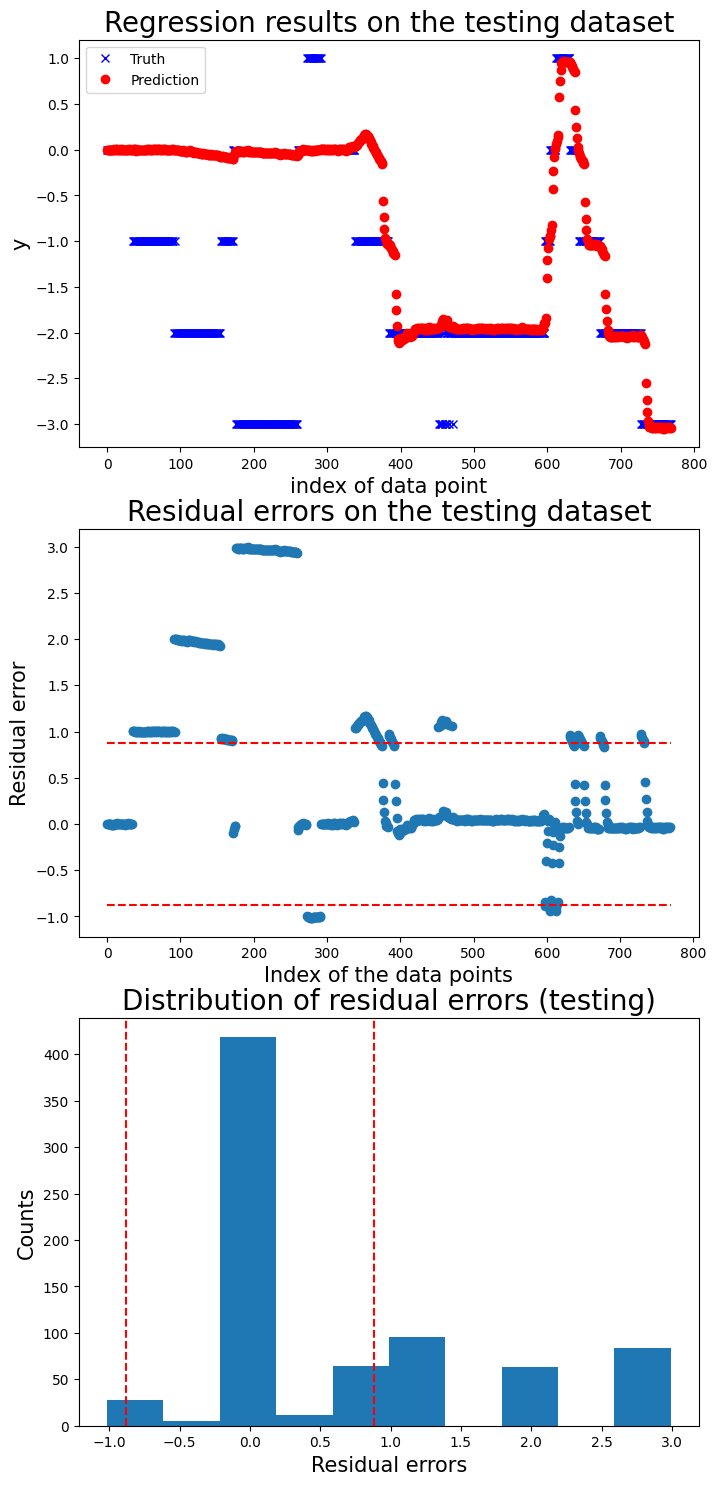

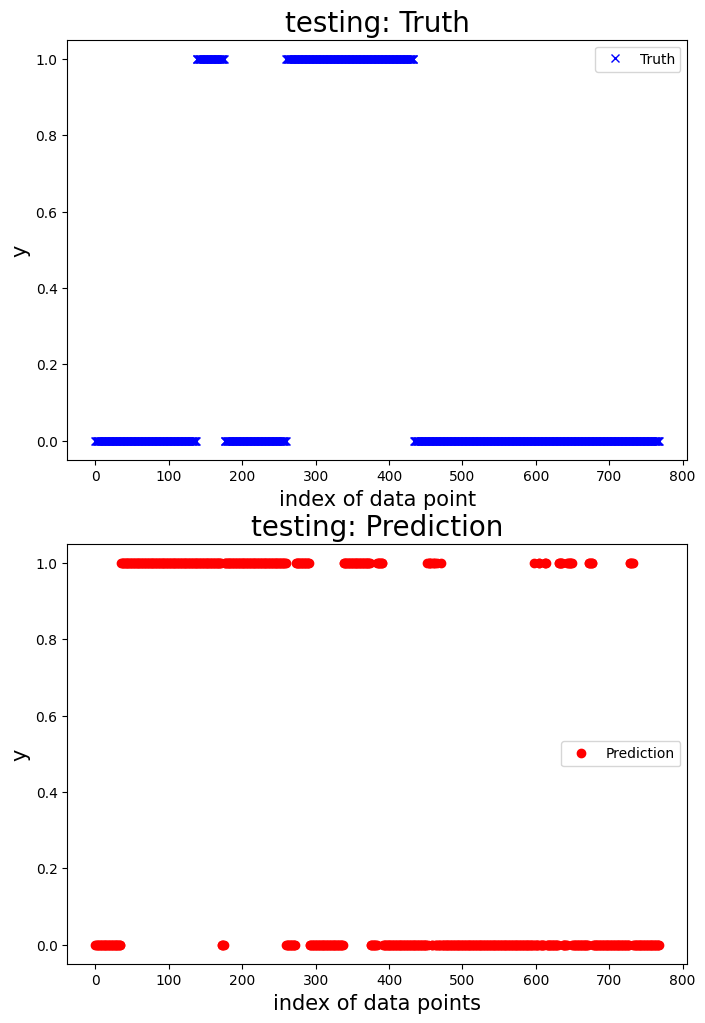

   Accuracy  Precision    Recall  F1 score
0  0.962372   0.920273  0.652666  0.763705
1  0.869955   0.778947  0.902439  0.836158
2  0.927536   1.000000  0.689922  0.816514
3  0.972973   1.000000  0.555556  0.714286
4  0.698510   0.502488  0.873199  0.637895
5  0.803723   0.952736  0.797917  0.868481
6  0.556567   0.301538  0.462264  0.364991


Mean performance metric and standard error:
Accuracy: 0.8274 +- 0.1537
Precision: 0.7794 +- 0.2745
Recall: 0.7049 +- 0.1634
F1 score: 0.7146 +- 0.1729




In [19]:
# Test the class FaultDetectReg

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from utility import read_all_test_data_from_path, extract_selected_feature, prepare_sliding_window, FaultDetectReg


def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 90, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = df['position'] - df['position'].iloc[0]


# Read data.
#base_dictionary = 'C:/Users/Zhiguo/OneDrive - CentraleSupelec/Code/Python/digital_twin_robot/projects/maintenance_industry_4_2024/dataset/training_data/'
base_dictionary='../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

# Pre-train the model.
# Get all the normal data.
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213',
    '20240325_152902', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']

df_tr = df_data[df_data['test_condition'].isin(normal_test_id)]

feature_list_all = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

# Prepare feature and response of the training dataset.
x_tr_org, y_temp_tr_org = extract_selected_feature(df_data=df_tr, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')

# Enrich the features based on the sliding window.
window_size = 9
sample_step = 1
prediction_lead_time = 1
threshold = 0.85
abnormal_limit = 3.5

x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr_org, y=y_temp_tr_org, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')

# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', Ridge(alpha=.65))    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)
# Fit the model
mdl = mdl_linear_regreession.fit(x_tr, y_temp_tr)

# Test data.
test_id = [
    '20240325_155003',
    '20240425_093699',
    '20240425_094425',
    '20240426_140055',
    '20240503_163963',
    '20240503_164675',
    '20240503_165189'
]
df_test = df_data[df_data['test_condition'].isin(test_id)]

# Define the fault detector.
detector_reg = FaultDetectReg(reg_mdl=mdl, threshold=threshold, abnormal_limit=abnormal_limit, window_size=window_size, sample_step=sample_step, pred_lead_time=prediction_lead_time)

# # Run cross validation
n_fold = 7
_, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='clf')
x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')

motor_idx = 6
print(f'Model for motor {motor_idx}:')
# Run cross validation.
df_perf = detector_reg.run_cross_val(df_x=x_test_org, y_label=y_label_test_org, y_response=y_temp_test_org, 
                                        n_fold=n_fold)
print(df_perf)
print('\n')
# Print the mean performance and standard error.
print('Mean performance metric and standard error:')
for name, metric, error in zip(df_perf.columns, df_perf.mean(), df_perf.std()):
    print(f'{name}: {metric:.4f} +- {error:.4f}') 
print('\n')

Model for motor 6:


100%|██████████| 1/1 [00:06<00:00,  6.62s/it]



 New run:

testing performance, max error is: 4.337164412149295
testing performance, mean root square error is: 1.7067578023473255
testing performance, residual error > 1.310124207648836: 45.99638771824202%

 New run:

testing performance, accuracy is: 0.5291992775436484
testing performance, precision is: 0.08989865969271003
testing performance, recall: 0.44426494345718903
testing performance, F1: 0.14953779227841218




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


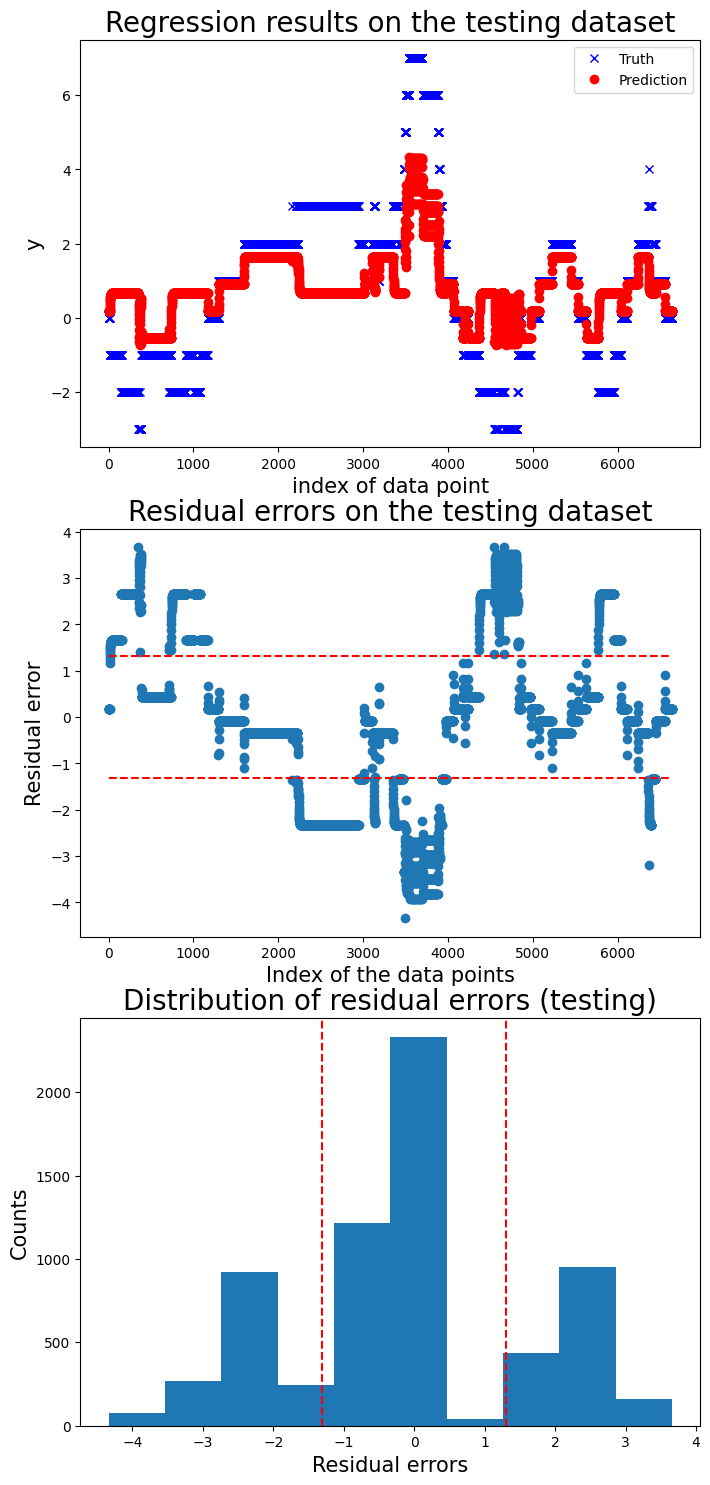

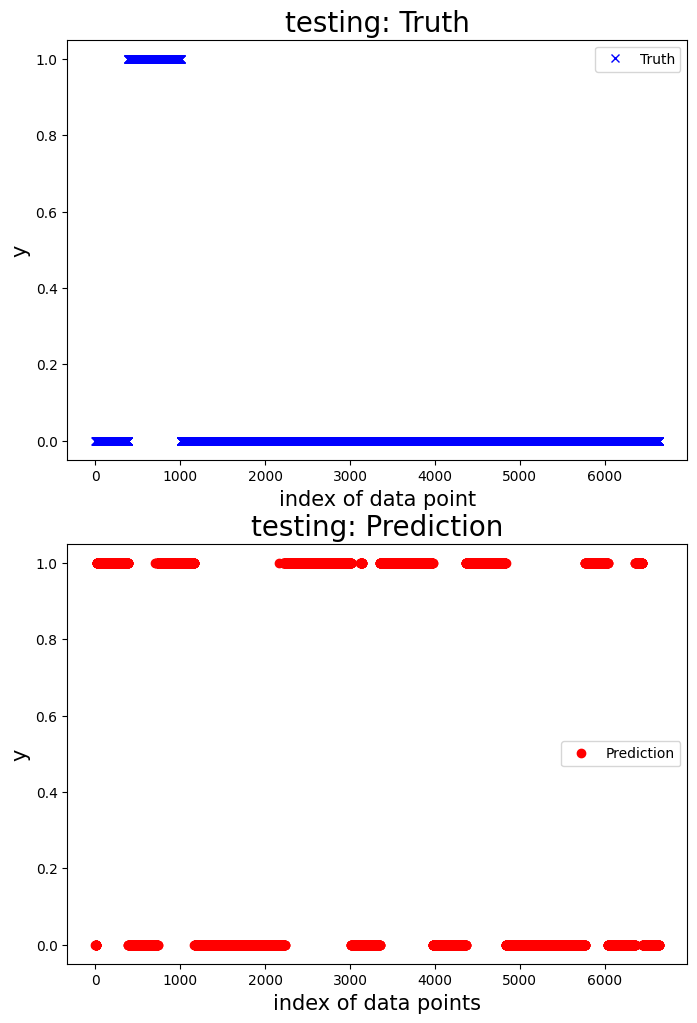

100%|██████████| 1/1 [00:00<00:00,  4.94it/s]



 New run:

testing performance, max error is: 4.574076812465165
testing performance, mean root square error is: 1.5456374212525998
testing performance, residual error > 0.85: 30.493273542600896%

 New run:

testing performance, accuracy is: 0.9372197309417041
testing performance, precision is: 1.0
testing performance, recall: 0.8292682926829268
testing performance, F1: 0.9066666666666666




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


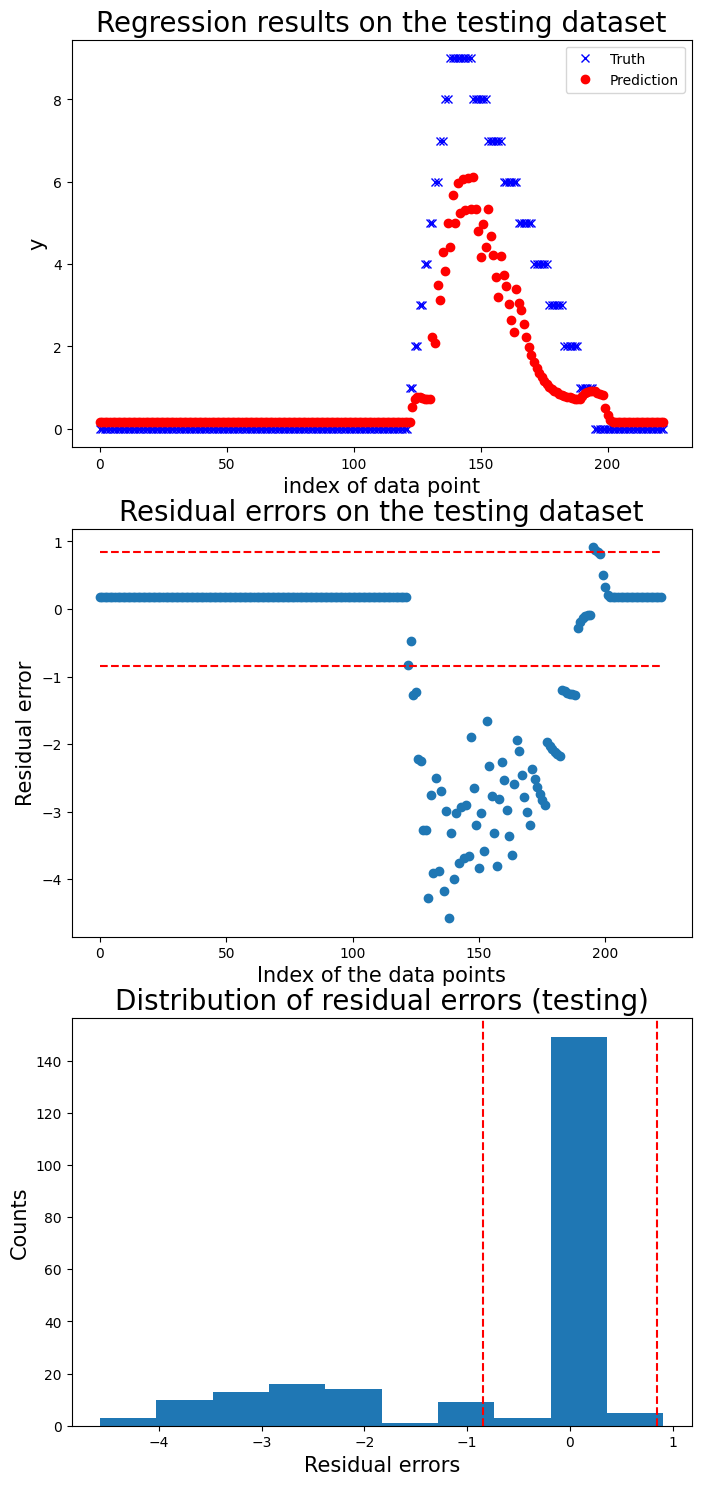

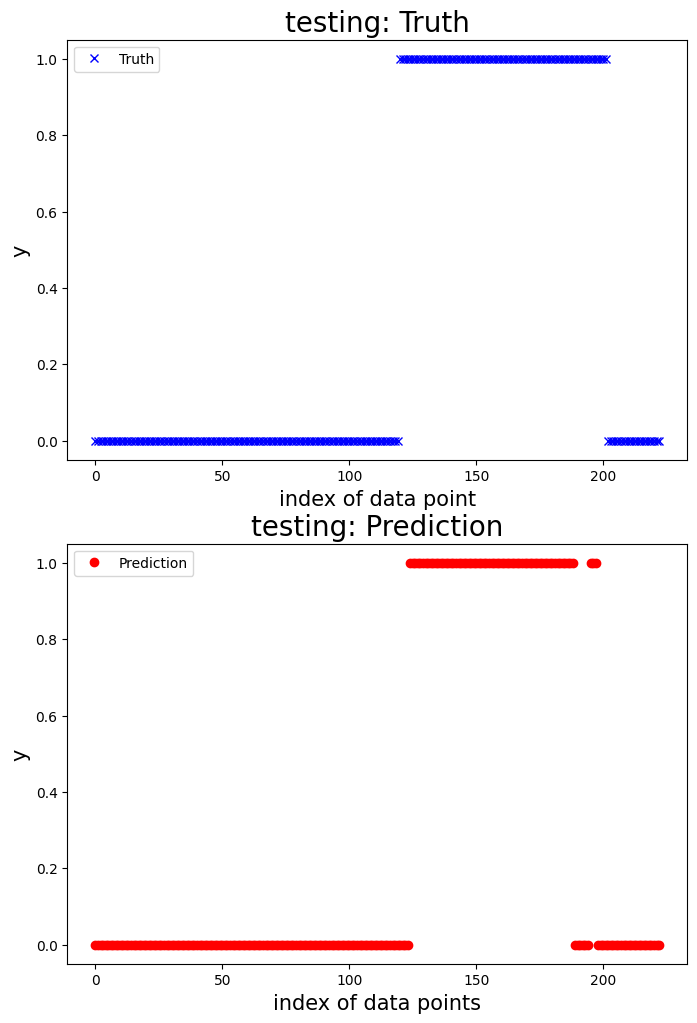

100%|██████████| 1/1 [00:00<00:00,  2.25it/s]



 New run:

testing performance, max error is: 2.329967146172855
testing performance, mean root square error is: 0.5262895677425612
testing performance, residual error > 0.85: 9.782608695652174%

 New run:

testing performance, accuracy is: 0.8641304347826086
testing performance, precision is: 1.0
testing performance, recall: 0.4186046511627907
testing performance, F1: 0.5901639344262295




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


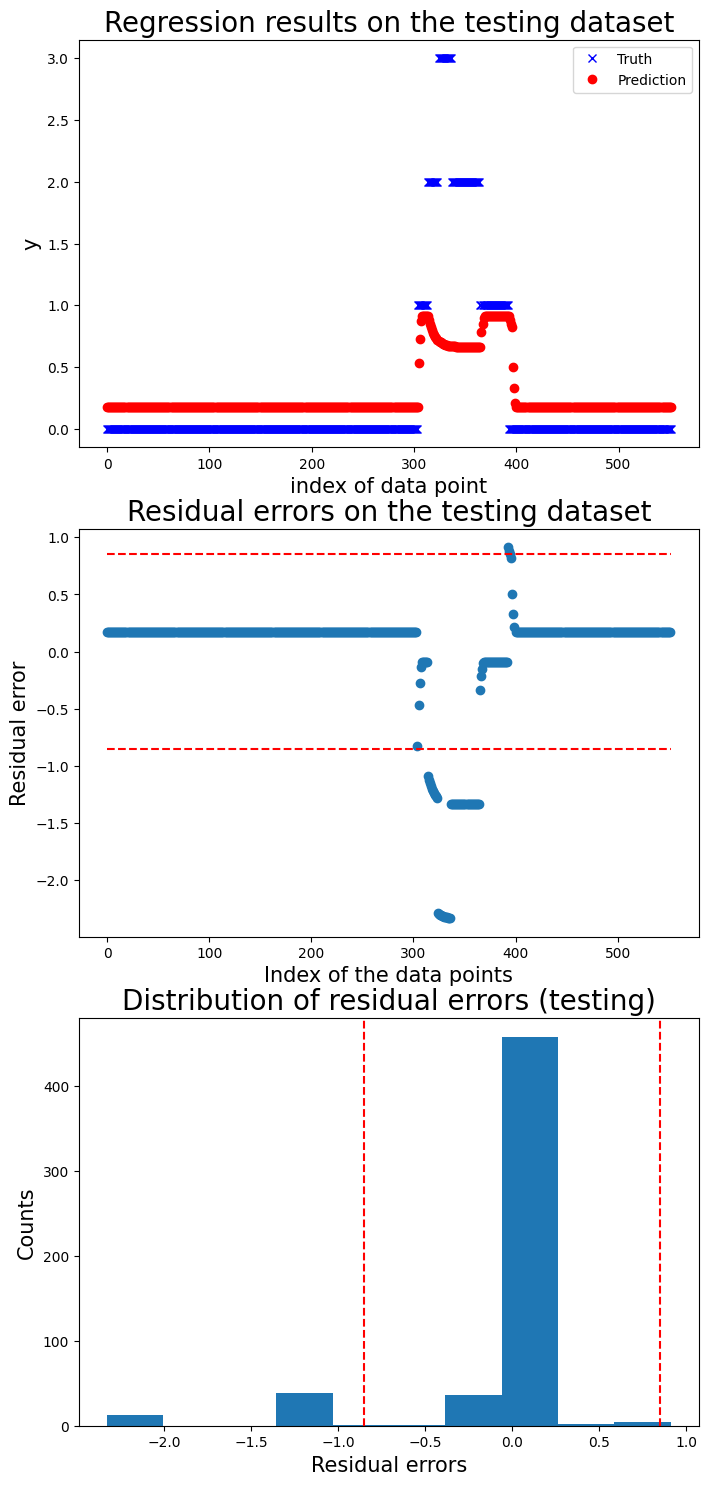

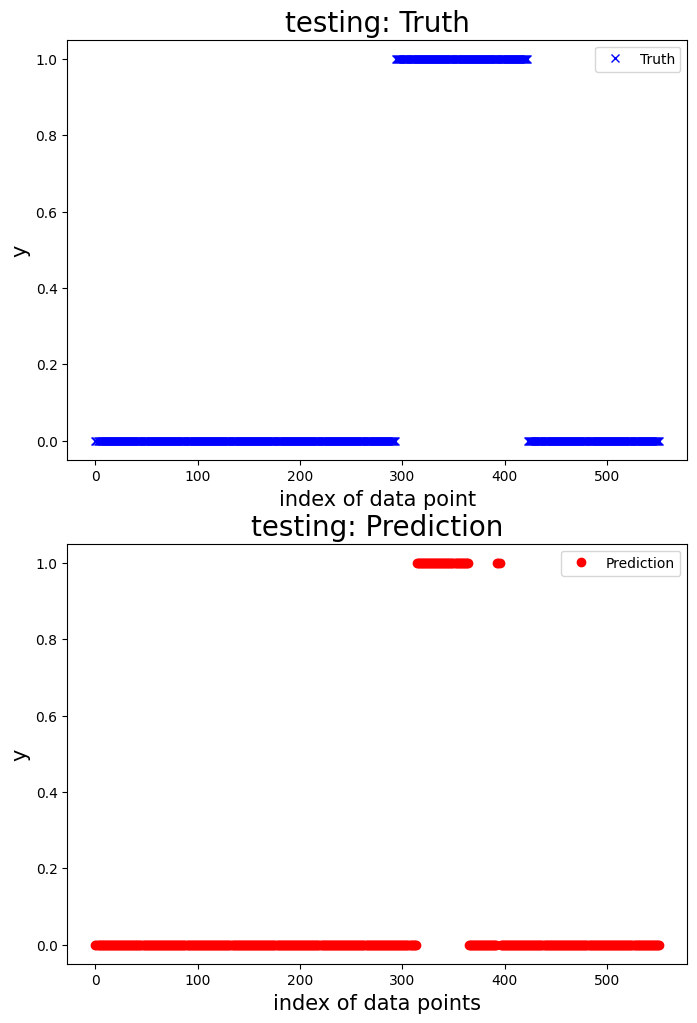

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]



 New run:

testing performance, max error is: 1.2401936139751053
testing performance, mean root square error is: 0.20815672376071387
testing performance, residual error > 0.85: 0.9652509652509652%

 New run:

testing performance, accuracy is: 0.9488416988416989
testing performance, precision is: 1.0
testing performance, recall: 0.15873015873015872
testing performance, F1: 0.273972602739726




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


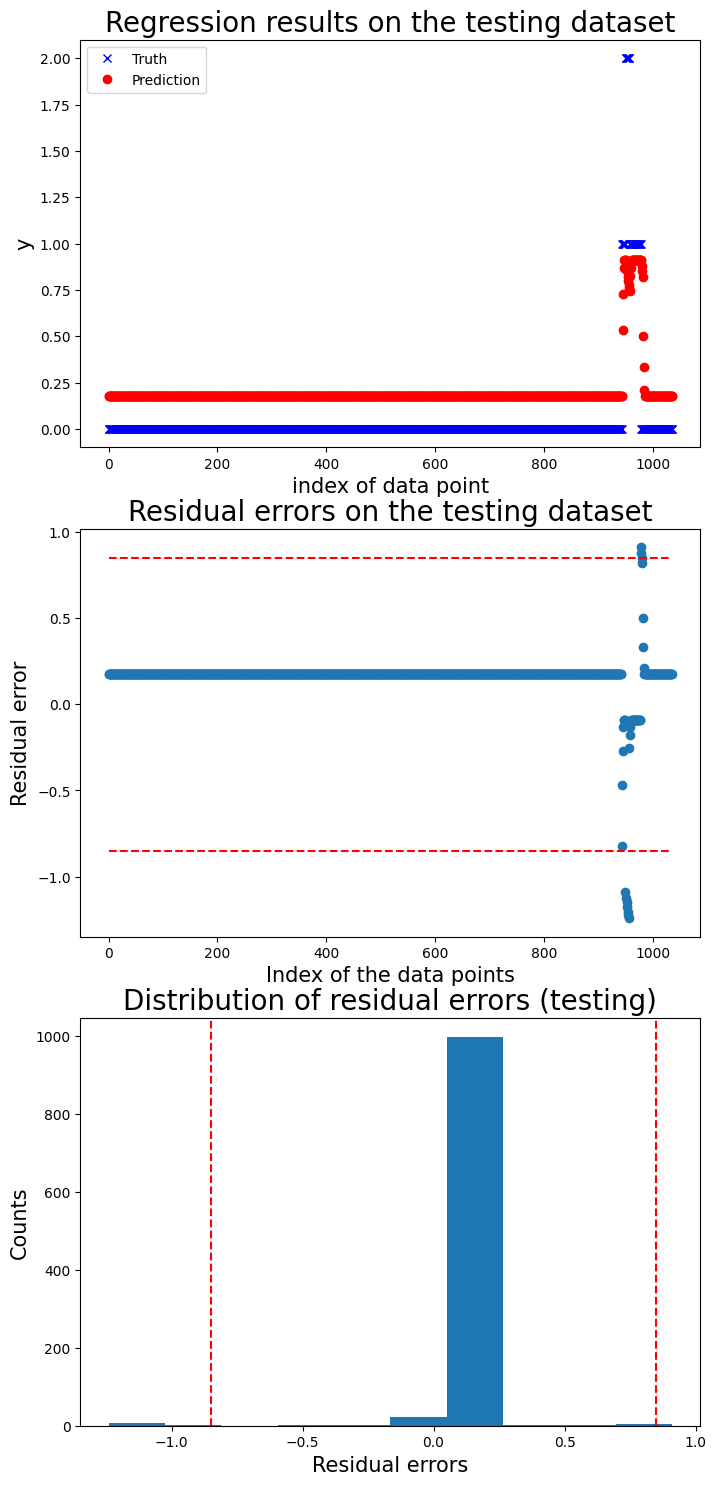

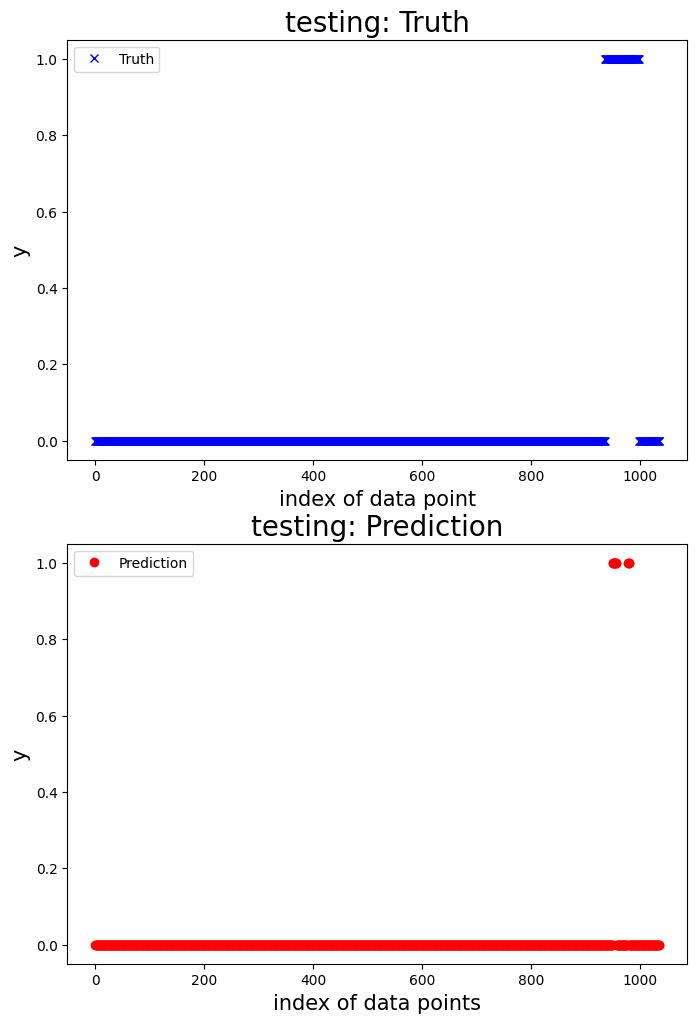

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]



 New run:

testing performance, max error is: 4.556560269394032
testing performance, mean root square error is: 2.0353349072252516
testing performance, residual error > 0.85: 45.74934268185802%

 New run:

testing performance, accuracy is: 0.8150744960560912
testing performance, precision is: 0.6302681992337165
testing performance, recall: 0.9481268011527377
testing performance, F1: 0.757192174913694




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


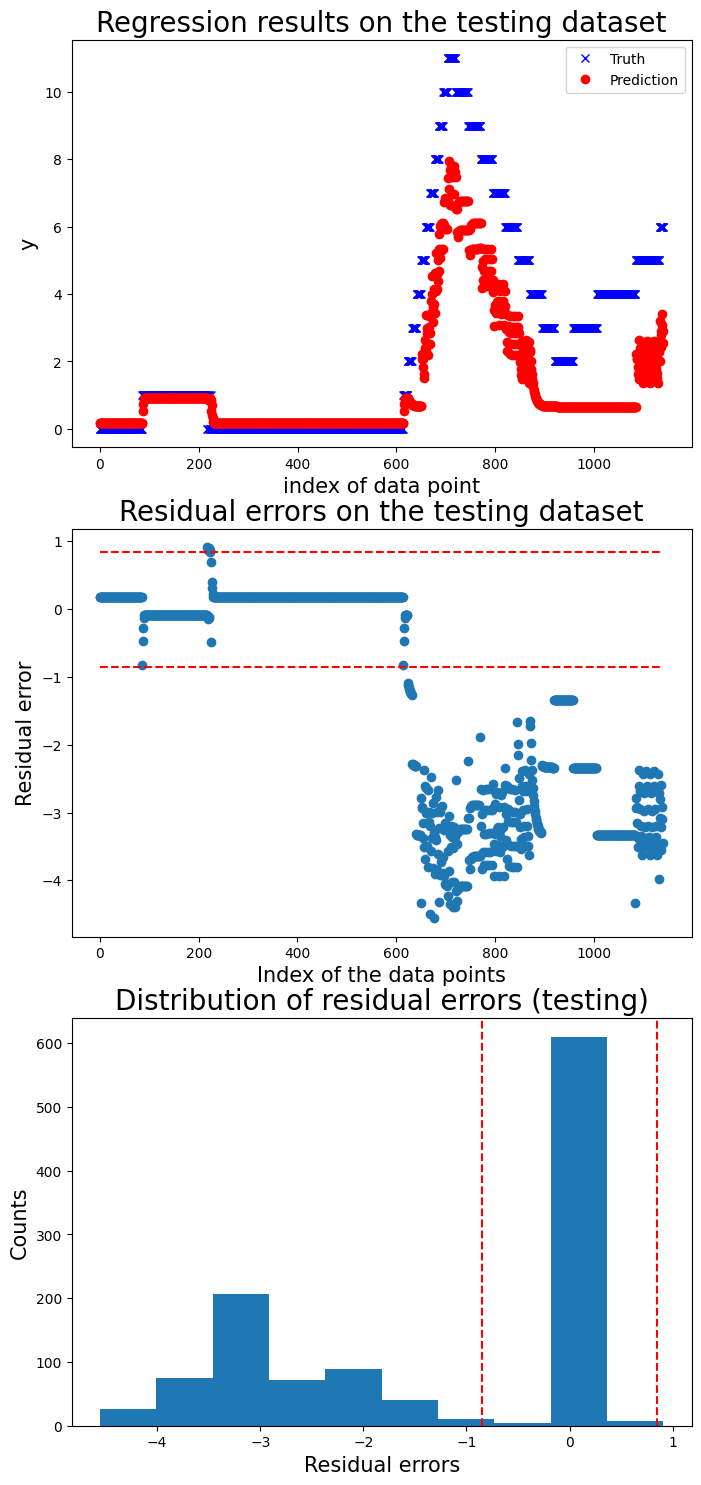

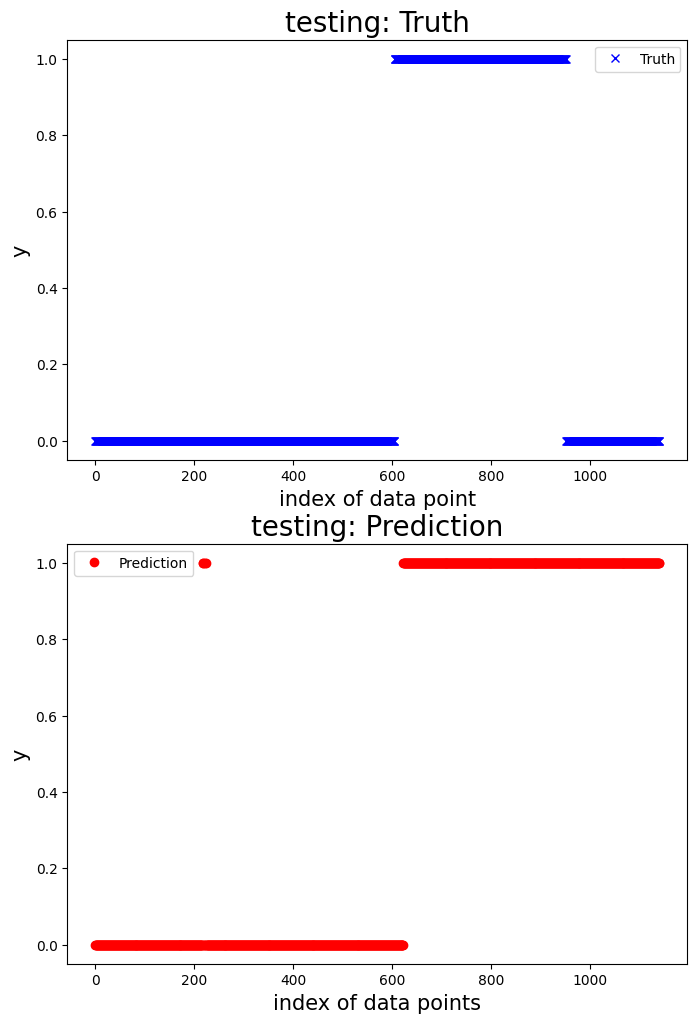

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



 New run:

testing performance, max error is: 5.389540964625816
testing performance, mean root square error is: 3.1026922974210227
testing performance, residual error > 0.85: 81.04906937394247%

 New run:

testing performance, accuracy is: 0.934010152284264
testing performance, precision is: 0.9603340292275574
testing performance, recall: 0.9583333333333334
testing performance, F1: 0.959332638164755




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


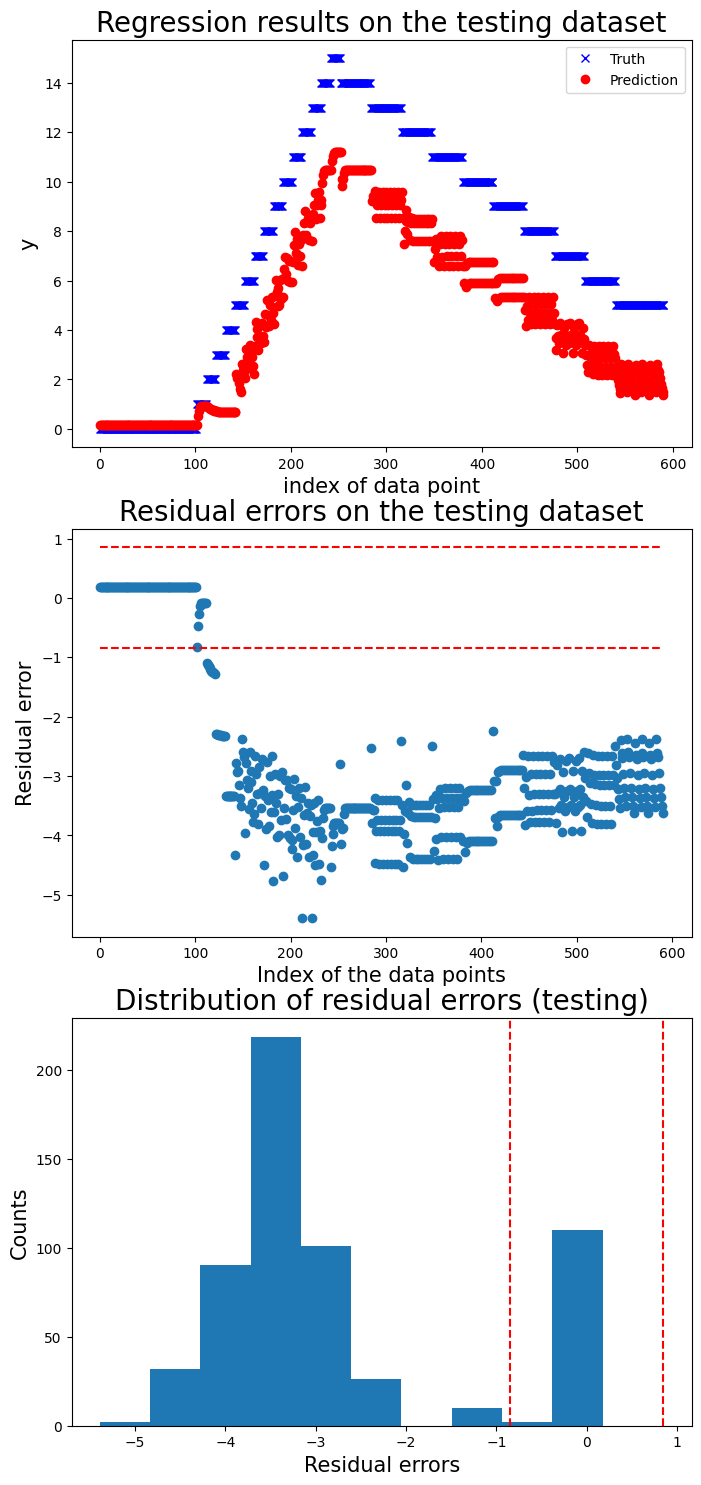

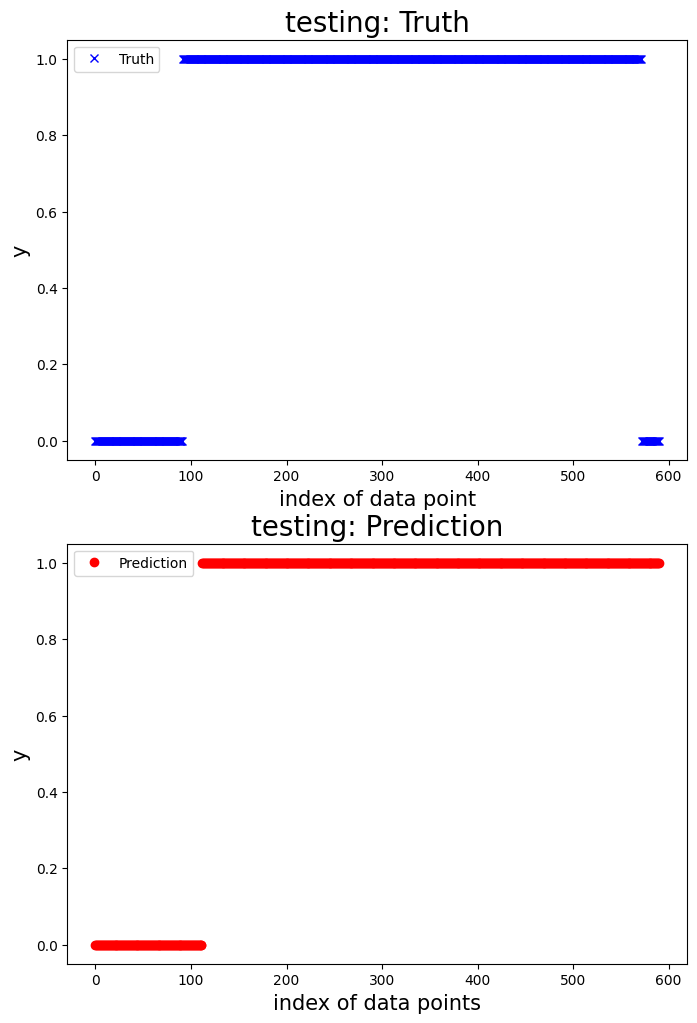

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]



 New run:

testing performance, max error is: 3.6628355830693877
testing performance, mean root square error is: 2.2523103775241715
testing performance, residual error > 1.1096438288049864: 79.71391417425228%

 New run:

testing performance, accuracy is: 0.26527958387516254
testing performance, precision is: 0.21207177814029363
testing performance, recall: 0.6132075471698113
testing performance, F1: 0.3151515151515151




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


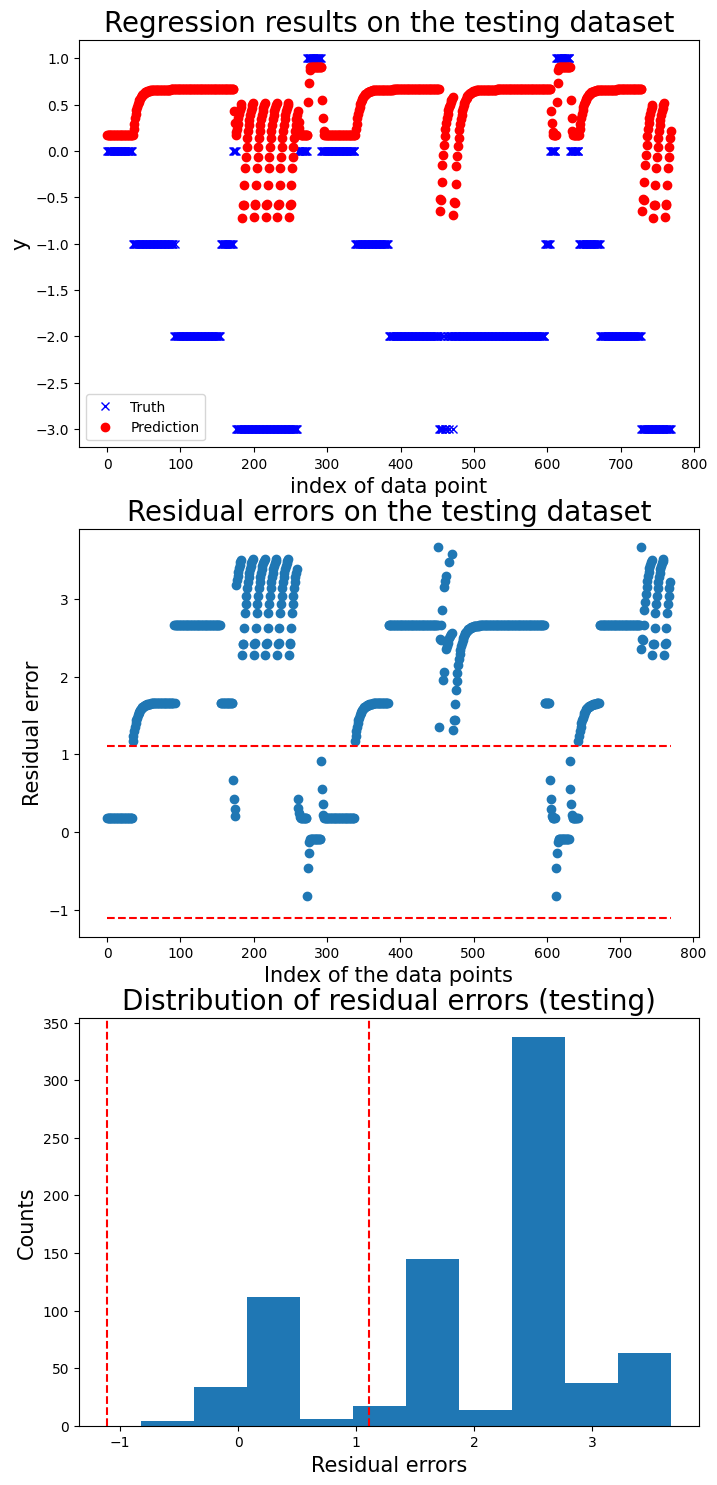

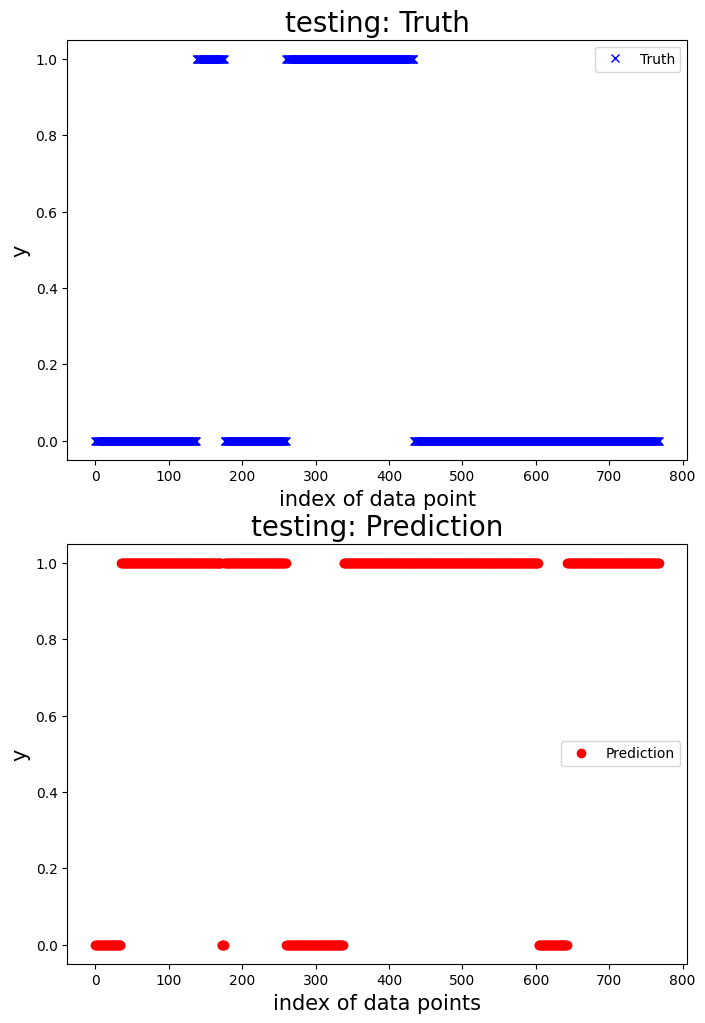

   Accuracy  Precision    Recall  F1 score
0  0.529199   0.089899  0.444265  0.149538
1  0.937220   1.000000  0.829268  0.906667
2  0.864130   1.000000  0.418605  0.590164
3  0.948842   1.000000  0.158730  0.273973
4  0.815074   0.630268  0.948127  0.757192
5  0.934010   0.960334  0.958333  0.959333
6  0.265280   0.212072  0.613208  0.315152


Mean performance metric and standard error:
Accuracy: 0.7563 +- 0.2611
Precision: 0.6989 +- 0.3985
Recall: 0.6244 +- 0.3028
F1 score: 0.5646 +- 0.3239




In [20]:
# Test the class FaultDetectReg

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from utility import read_all_test_data_from_path, extract_selected_feature, prepare_sliding_window, FaultDetectReg


def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 90, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = df['position'] - df['position'].iloc[0]


# Read data.
#base_dictionary = 'C:/Users/Zhiguo/OneDrive - CentraleSupelec/Code/Python/digital_twin_robot/projects/maintenance_industry_4_2024/dataset/training_data/'
base_dictionary='../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

# Pre-train the model.
# Get all the normal data.
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213',
    '20240325_152902', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']

df_tr = df_data[df_data['test_condition'].isin(normal_test_id)]

feature_list_all = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

# Prepare feature and response of the training dataset.
x_tr_org, y_temp_tr_org = extract_selected_feature(df_data=df_tr, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')

# Enrich the features based on the sliding window.
window_size = 9
sample_step = 1
prediction_lead_time = 1
threshold = 0.85
abnormal_limit = 3.5

x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr_org, y=y_temp_tr_org, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')

# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', Lasso(alpha=.65))    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)
# Fit the model
mdl = mdl_linear_regreession.fit(x_tr, y_temp_tr)

# Test data.
test_id = [
    '20240325_155003',
    '20240425_093699',
    '20240425_094425',
    '20240426_140055',
    '20240503_163963',
    '20240503_164675',
    '20240503_165189'
]
df_test = df_data[df_data['test_condition'].isin(test_id)]

# Define the fault detector.
detector_reg = FaultDetectReg(reg_mdl=mdl, threshold=threshold, abnormal_limit=abnormal_limit, window_size=window_size, sample_step=sample_step, pred_lead_time=prediction_lead_time)

# # Run cross validation
n_fold = 7
_, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='clf')
x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')

motor_idx = 6
print(f'Model for motor {motor_idx}:')
# Run cross validation.
df_perf = detector_reg.run_cross_val(df_x=x_test_org, y_label=y_label_test_org, y_response=y_temp_test_org, 
                                        n_fold=n_fold)
print(df_perf)
print('\n')
# Print the mean performance and standard error.
print('Mean performance metric and standard error:')
for name, metric, error in zip(df_perf.columns, df_perf.mean(), df_perf.std()):
    print(f'{name}: {metric:.4f} +- {error:.4f}') 
print('\n')

## Summary of the results

Please add a table in the end, summarying the results from all the models (including the unsupervised learning models). Please write a few texts to explain what is the best model you got (including key parameters like threshold, window_size, sample_step, prediction_lead_time, etc), its performance, and how could you further improve it.

We got these results for :

threshold = 0.9

window_size=9

sample_step=1

prediction_lead_time=1

| Model   | Accuracy | Precision | Recall | F1   |
|---------|----------|-----------|--------|------|
| Linear Regression |   83.12%  |   74.98%   | 66.15% | 68.66%|
| Ridge Regression |   82.74%  |   77.94%   |  70.49% | 71.46%|
| Lasso Regression |   75.63%  |   69.89%   |  62.44% | 56.45%|

We tried to modify the parameters given but the reslting metrics were worse everytime for all the models (even logistic regression and SVM).

We also tried to take less features into consideration but same thing.

The MinMaxScalar however works better than the StandardScalar.
